# Extensive Study on Venues Around Neighborhoods of Toronto and New York City

## Objective

There are two objectives of this project. First, is to identify the similarities and dissimilarities between the neighborhoods of Toronto and New York City in terms of venues exist around them using K Means Clustering algorithm. Second, is to identify the business opportunities related to food industry in each neighborhood based on the venues exist around it, most common venues of that particular cluster it fall under, and most common venues of the borough it belongs to

## Data

The list of Toronto’s boroughs and neighborhoods was extracted from Wikipedia page which has it in Tabular format. The link of the page is https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Latitude and longitude of all those neighborhoods were provided by IBM in “.csv” format

The dataset of NYC’s boroughs and neighborhoods was imported in JSON format using this link https://cocl.us/new_york_dataset. From the dataset imported in the JSON format, useful features like name of the borough, name of the neighborhood, and their latitude and longitude were obtained and put them into pandas dataframe. As the dataset was already properly structured in the JSON format, there was again no necessity to modify it or clean it. 

Foursquare location data was used to explore the venues exist around each neighborhood of both the cities.


In [919]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns #Seaborn for Data Visualization

import folium # map rendering library

from sklearn.cluster import KMeans

import math

print('Libraries imported.')

Libraries imported.


In [1292]:
#Population data of NYC boroughs just for the reference 

nycinfo_df = pd.read_excel("nycinfo.xlsx", sheet_name="Sheet1", header=2, usecols=[1,2,3,4])
nycinfo_df.dropna(inplace = True)
nycinfo_df

Borough  Population Estimate (2019)  Square Miles  \
1          Bronx                   1418207.0         42.10   
2       Brooklyn                   2559903.0         70.82   
3      Manhattan                   1628706.0         22.83   
4         Queens                   2253858.0        108.53   
5  Staten Island                    476143.0         58.37   

   Population density           (per square mile)   
1                                          33867.0  
2                                          36147.0  
3                                          71341.0  
4                                          20767.0  
5                                           8157.0

In [1299]:
#Population data of Toronto boroughs just for the reference 

torontoinfo_df = pd.read_excel("NYC_TORONTO.xlsx")
torontoinfo_df.dropna(inplace = True)
torontoinfo_df

Borough   Area Population   \
0  Old Toronto (West  + East + Central + Downtown)  37.51    7,97,642   
1                                       North York  68.29    8,69,401   
2                                      Scarborough  72.47    6,32,098   
3                                        Etobicoke  47.85    3,65,143   
4                                             York   9.07    1,45,662   
5                                        East York   8.21    1,18,071   

  Population Density (per square mile)  
0                                21265  
1                                12731  
2                                 8722  
3                                 7631  
4                                16060  
5                                14384

#### Importing data of Toronto's boroughs and neighborhoods

In [1301]:
#URL to the page which has got the information of various neighborhoods associated with different Boroughs of Toronto
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

#Directly reading the html file using pandas library
df = pd.read_html(url)[0]

#Glimpse of the Dataframe
df.head()

Postal Code           Borough               Neighborhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [1302]:
#Dropping all the records which do not have any value assigned to "Borough"
df.drop(df[df["Borough"] == "Not assigned"].index,inplace = True)

#Resetting the index
df.reset_index(drop = True, inplace = True)

#Replacing all the '/' of the Neighboorhood values with ","
df["Neighborhood"] = df["Neighborhood"].str.replace("/",",")

# Glimpse of the Dataframe
df.head()

Postal Code           Borough                                 Neighborhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

Some of the neighborhoods are already combined as they are very close to each other and so they share the same postal code as well. We can see the example right above (Regent Park, Harbourfront). These two are two seperate neighborhoods but considered as one as they are very close by and share the same postal code

In [1303]:
#Grabbing the already provided csv file of longitudes and Latitudes of the neighborhoods based on their postal codes

postal_code_df = pd.read_csv("Geospatial_Coordinates.csv")
postal_code_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [1304]:
#Merging both the dataframes 
toronto_df = df.merge(postal_code_df, how = "left", left_on= "Postal Code", right_on="Postal Code")

#Dropping the additional "Postal Code" column generated because of the merging operation
toronto_df.drop("Postal Code", axis = 1, inplace = True)

#Glimpse of the final dataframe
toronto_df.head()

Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [1305]:
print('The dataframe has {} unique boroughs, {} unique neighborhoods, and {} data rows'.format(
                                                                                toronto_df['Borough'].nunique(), 
                                                                                toronto_df["Neighborhood"].nunique(),
                                                                                toronto_df.shape[0]))

The dataframe has 10 unique boroughs, 99 unique neighborhoods, and 103 data rows


In [10]:
#Checking the number of records exist for each Borough in the final dataframe
toronto_df["Borough"].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
York                 5
East York            5
Mississauga          1
Name: Borough, dtype: int64

#### "toronto_df" is going to remain the reference dataframe to get the latitude and longitude of the neighborhoods when exploring the venues exist around them

#### Importing data of NYC's boroughs and neighborhoods

In [11]:
#Importing necessary libraries to import the from net in json format

import urllib, json
url = h
response = urllib.request.urlopen(url)
data = json.loads(response.read())
print (data)

{'type': 'FeatureCollection', 'totalFeatures': 306, 'features': [{'type': 'Feature', 'id': 'nyu_2451_34572.1', 'geometry': {'type': 'Point', 'coordinates': [-73.84720052054902, 40.89470517661]}, 'geometry_name': 'geom', 'properties': {'name': 'Wakefield', 'stacked': 1, 'annoline1': 'Wakefield', 'annoline2': None, 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.84720052054902, 40.89470517661, -73.84720052054902, 40.89470517661]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.2', 'geometry': {'type': 'Point', 'coordinates': [-73.82993910812398, 40.87429419303012]}, 'geometry_name': 'geom', 'properties': {'name': 'Co-op City', 'stacked': 2, 'annoline1': 'Co-op', 'annoline2': 'City', 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.82993910812398, 40.87429419303012, -73.82993910812398, 40.87429419303012]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.3', 'geometry': {'type': 'Point', 'coordinates': [-73.82780644716412, 40.887555677350775]}, 'geometry_n

In [12]:
nyc_data = data['features'] #Grabbing all the features of the json data
nyc_data

[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

In [13]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] #These are only 4 required parameters for this project

# instantiating the dataframe 
nyc_df = pd.DataFrame(columns=column_names)
nyc_df

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [14]:
#Grabbing the required data from the json file and putting it into a dataframe "nyc_df"

for data in nyc_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_df = nyc_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
nyc_df.head() #Glimpse of the final dataframe

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [820]:
print("nyc_df has {} unique boroughs, {} unique neighborhoods, and total {} data rows".format(nyc_df["Borough"].nunique(), 
                                                                                         nyc_df["Neighborhood"].nunique(), 
                                                                                         nyc_df.shape[0])) 

nyc_df has 5 unique boroughs, 302 unique neighborhoods, and total 306 data rows


In [16]:
#Checking the number of records exist for each Borough in the final dataframe
nyc_df["Borough"].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

#### "nyc_df" is going to remain the reference dataframe to get the latitude and longitude of the neighborhoods when exploring the venues exist around them

Now, geographically mapping all these neighborhoods of Toronto and NYC using their Longitude and Latitude values

In [144]:
#Getting coordinates of NYC and Toronto
address = ['New York City, NY', 'Toronto, ON']

for i in range(0,2):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address[i])
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address[i],latitude, longitude))

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.
The geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


In [821]:
toronto_nyc_concat = pd.concat([toronto_df, nyc_df], ignore_index=True)
toronto_nyc_concat.head(3)

Borough               Neighborhood   Latitude  Longitude
0        North York                  Parkwoods  43.753259 -79.329656
1        North York           Victoria Village  43.725882 -79.315572
2  Downtown Toronto  Regent Park, Harbourfront  43.654260 -79.360636

In [822]:
#Mapping all the neighborhoods of the dataframe


toronto_nyc_map = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_nyc_concat['Latitude'], toronto_nyc_concat['Longitude'], 
                                           toronto_nyc_concat['Borough'], toronto_nyc_concat['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_nyc_map)  
    

toronto_nyc_map

The plot above shows all the neighborhoods of Toronto and NYC. The plot after appying clustering algorithm is shown later in the notebook

#### Now, using Foursquare's locatio data to explore different venues located around all these neighborhoods within certain distance to each neighborhood

In [21]:
# Define Foursquare Credentials and Version
CLIENT_ID = '02KKOKDRFRUGOAISBXATZADDF5UX3ZZ1RGV2HCQX2D04AWUF' # your Foursquare ID
CLIENT_SECRET = 'KDN1BDJHEKMFB2INWQODS0KTEZJOX4CJTAUZ111GILVUQQNA' # your Foursquare Secret
VERSION = '20200503' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 02KKOKDRFRUGOAISBXATZADDF5UX3ZZ1RGV2HCQX2D04AWUF
CLIENT_SECRET:KDN1BDJHEKMFB2INWQODS0KTEZJOX4CJTAUZ111GILVUQQNA


Getting the data for 100 different venues around each neighborhood within 500 meters (0.3 miles) of radius

In [22]:
#Function that would grab 100 venues within 500 meters of each neighborhood

def getNearbyVenues(borough_name, neighborhood_name, latitudes, longitudes, RADIUS=500):
    LIMIT = 100
    venues_list=[]
    for bor_name, nei_name, lat, lng in zip(borough_name, neighborhood_name, latitudes, longitudes):
        print(nei_name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(bor_name,
            nei_name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [140]:
#Using the function above to grab 100 venues within 500 meters of each neighborhood of Toronto

toronto_venues = getNearbyVenues(borough_name = toronto_df["Borough"],
                                   neighborhood_name=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [217]:
toronto_venues.head() #Glimpse of the dataframe

Borough      Neighborhood  Neighborhood Latitude  \
0  North York         Parkwoods              43.753259   
1  North York         Parkwoods              43.753259   
2  North York  Victoria Village              43.725882   
3  North York  Victoria Village              43.725882   
4  North York  Victoria Village              43.725882   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0              -79.329656         Brookbanks Park       43.751976   
1              -79.329656           Variety Store       43.751974   
2              -79.315572  Victoria Village Arena       43.723481   
3              -79.315572             Tim Hortons       43.725517   
4              -79.315572               Portugril       43.725819   

   Venue Longitude         Venue Category  
0       -79.332140                   Park  
1       -79.333114      Food & Drink Shop  
2       -79.315635           Hockey Arena  
3       -79.313103            Coffee Shop  
4       -79.312785  Portuguese Restaurant

In [823]:
print("toronto_venues has {} unique neighborhoods and {} data rows".format(toronto_venues["Neighborhood"].nunique(), 
                                                                           toronto_venues.shape[0])) 

toronto_venues has 93 unique neighborhoods and 2116 data rows


The main dataframe toronto_df had 98 unique neighborhoods whereas toronto_venues has 93 unique neighborhoods "toronto_venues" which indicates that we did not find any venues existing within 500 meters (0.3 miles) of radius of 5 neighborhoods. Those missing neighborhoods with their borough names are 1) Islington Avenue (Etobicoke) 2) Upper Rouge (Scarborough) 3) Weston (York) 4) Willowdale, Newtonbrook (North York) 5) York Mills, Silver Hills (North York)

Converting all the venue categories in "0's" and "1's". 1 means the venue does exist around that neighborhood and 0 means it doesn't

In [824]:
toronto_dummies = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_dummies['Borough'] = toronto_venues['Borough']
toronto_dummies['Neighborhood'] = toronto_venues['Neighborhood']


toronto_dummies.head()

Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                  0                  0        0                   0   
1                  0                  0        0                   0   
2                  0                  0        0                   0   
3                  0                  0        0                   0   
4                  0                  0        0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0         0            0           0                    0   
1             0         0            0           0                    0   
2             0         0            0           0                    0   
3             0         0            0           0                    0   
4             0         0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0                 0                   0            0              0   
1                 0                   0            0              0   
2                 0                   0            0              0   
3                 0                   0            0              0   
4                 0                   0            0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0                0         0           0                   0   
1                0         0           0                   0   
2                0         0           0                   0   
3                0         0           0                   0   
4                0         0           0                   0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Boat or Ferry  Bookstore  \
0                         0          0       0              0          0   
1                         0          0       0              0          0   
2                         0          0       0              0          0   
3                         0          0       0              0          0   
4                         0          0       0              0          0   

   Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0         0                     0               0        0            0   
1         0                     0               0        0            0   
2         0                     0               0        0            0   
3         0                     0               0        0            0   
4         0                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0    

As there are more than one neighborhoods name included in some of the neighborhoods as shown earlier, I decided to keep just first name of those neighborhoods so it becomes more readable and help to make the data visualization easier

In [825]:
 toronto_dummies["Neighborhood"] = toronto_dummies["Neighborhood"].str.split(",").str.get(0)

## Exploratory data analysis of borough's of Toronto

In [826]:
toronto_borough = toronto_dummies.groupby("Borough").sum() #Grouping by Borough 
toronto_borough

Accessories Store  Afghan Restaurant  Airport  \
Borough                                                           
Central Toronto                   0                  0        0   
Downtown Toronto                  0                  1        1   
East Toronto                      0                  0        0   
East York                         0                  0        0   
Etobicoke                         0                  0        0   
Mississauga                       0                  0        0   
North York                        1                  0        1   
Scarborough                       0                  0        0   
West Toronto                      0                  0        0   
York                              0                  0        0   

                  Airport Food Court  Airport Lounge  Airport Service  \
Borough                                                                 
Central Toronto                    0               0                0   
Downtown Toronto                   1               2                2   
East Toronto                       0               0                0   
East York                          0               0                0   
Etobicoke                          0               0                0   
Mississauga                        0               0                0   
North York                         0               0                0   
Scarborough                        0               0                0   
West Toronto                       0               0                0   
York                               0               0                0   

                  Airport Terminal  American Restaurant  Antique Shop  \
Borough                                                                 
Central Toronto                  0                    2             0   
Downtown Toronto                 2                   17             2   
East Toronto                     0                    3             0   
East York                        0                    0             0   
Etobicoke                        0                    1             0   
Mississauga                      0                    1             0   
North York                       0                    2             0   
Scarborough                      0                    1             0   
West Toronto                     0                    0             0   
York                             0                    0             0   

                  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
Borough                                                                    
Central Toronto          0            0           0                    0   
Downtown Toronto         5           12           2                    3   
East Toronto             0            0           0                    1   
East York                0            0           0                    0   
Etobicoke                0            0           0                    0   
Mississauga              0            0           0                    0   
North York               0            0           0                    1   
Scarborough              0            0           0                    0   
West Toronto             0            1           0                    1   
York                     0            0           0                    0   

                  Asian Restaurant  Athletics & Sports  Auto Garage  \
Borough                                                               
Central Toronto                  0                   0            0   
Downtown Toronto                 9                   1            0   
East Toronto                     0                   0            0   
East York                        0                   2            0   
Etobicoke                        0                   0            0   
Mississauga                      0               

In [1068]:
#Creating a dataframe which contains top venues of each borough

num = int(input("Number of top venues you would like to explore of each borough?"))
toronto_borough_characteristics = pd.DataFrame(columns=["Venue", "Count", "Borough"])
empty_df = pd.DataFrame()
for i in range(0,10):
    empty_df["Venue"] =  toronto_borough.iloc[i,:].iloc[0:].sort_values(ascending = False).index[0:num]
    empty_df["Count"] =  toronto_borough.iloc[i,:].iloc[0:].sort_values(ascending = False).values[0:num]
    empty_df["Borough"] = toronto_borough.index[i]
    toronto_borough_characteristics = pd.concat([toronto_borough_characteristics, empty_df], ignore_index=True)
toronto_borough_characteristics

Number of top venues you would like to explore of each borough?20


Venue Count           Borough
0                      Coffee Shop     9   Central Toronto
1                             Park     7   Central Toronto
2                   Sandwich Place     7   Central Toronto
3                      Pizza Place     7   Central Toronto
4                             Café     6   Central Toronto
5                       Restaurant     4   Central Toronto
6                     Dessert Shop     4   Central Toronto
7                 Sushi Restaurant     4   Central Toronto
8                   Clothing Store     4   Central Toronto
9                              Pub     3   Central Toronto
10                             Gym     3   Central Toronto
11                      Bagel Shop     2   Central Toronto
12              Italian Restaurant     2   Central Toronto
13                           Diner     2   Central Toronto
14               Indian Restaurant     2   Central Toronto
15                    Liquor Store     2   Central Toronto
16                        Pharmacy     2   Central Toronto
17                   Grocery Store     2   Central Toronto
18             American Restaurant     2   Central Toronto
19              Seafood Restaurant     2   Central Toronto
20                     Coffee Shop   121  Downtown Toronto
21                            Café    69  Downtown Toronto
22                      Restaurant    44  Downtown Toronto
23                           Hotel    32  Downtown Toronto
24             Japanese Restaurant    32  Downtown Toronto
25              Italian Restaurant    29  Downtown Toronto
26                          Bakery    22  Downtown Toronto
27              Seafood Restaurant    21  Downtown Toronto
28                             Gym    20  Downtown Toronto
29                            Park    20  Downtown Toronto
30                  Clothing Store    18  Downtown Toronto
31                        Beer Bar    17  Downtown Toronto
32             American Restaurant    17  Downtown Toronto
33                Sushi Restaurant    16  Downtown Toronto
34                             Bar    16  Downtown Toronto
35                 Thai Restaurant    15  Downtown Toronto
36                       Gastropub    15  Downtown Toronto
37                             Pub    15  Downtown Toronto
38                  Breakfast Spot    14  Downtown Toronto
39                   Deli / Bodega    14  Downtown Toronto
40                Greek Restaurant     9      East Toronto
41                     Coffee Shop     7      East Toronto
42                         Brewery     5      East Toronto
43                            Café     5      East Toronto
44              Italian Restaurant     5      East Toronto
45                  Ice Cream Shop     4      East Toronto
46                            Park     4      East Toronto
47                      Restaurant     4      East Toronto
48                     Pizza Place     3      East Toronto
49                  Sandwich Place     3      East Toronto
50                             Pub     3      East Toronto
51                          Bakery     3      East Toronto
52            Fast Food Restaurant     3      East Toronto
53             American Restaurant     3      East Toronto
54                       Bookstore     2      East Toronto
55                   Burrito Place     2      East Toronto
56                       Pet Store     2      East Toronto
57                             Spa     2      East Toronto
58                    Liquor Store     2      East Toronto
59                     Yoga Studio     2      East Toronto
60                     Coffee Shop     5         East York
61                            Park     4         East York
62                            Bank     4         East York
63                        Pharmacy     3         East York
64                     Pizza Place     3         East York
65                    Burger Joint     3         East York
66             Sporting Goods Shop     3         East York
67               

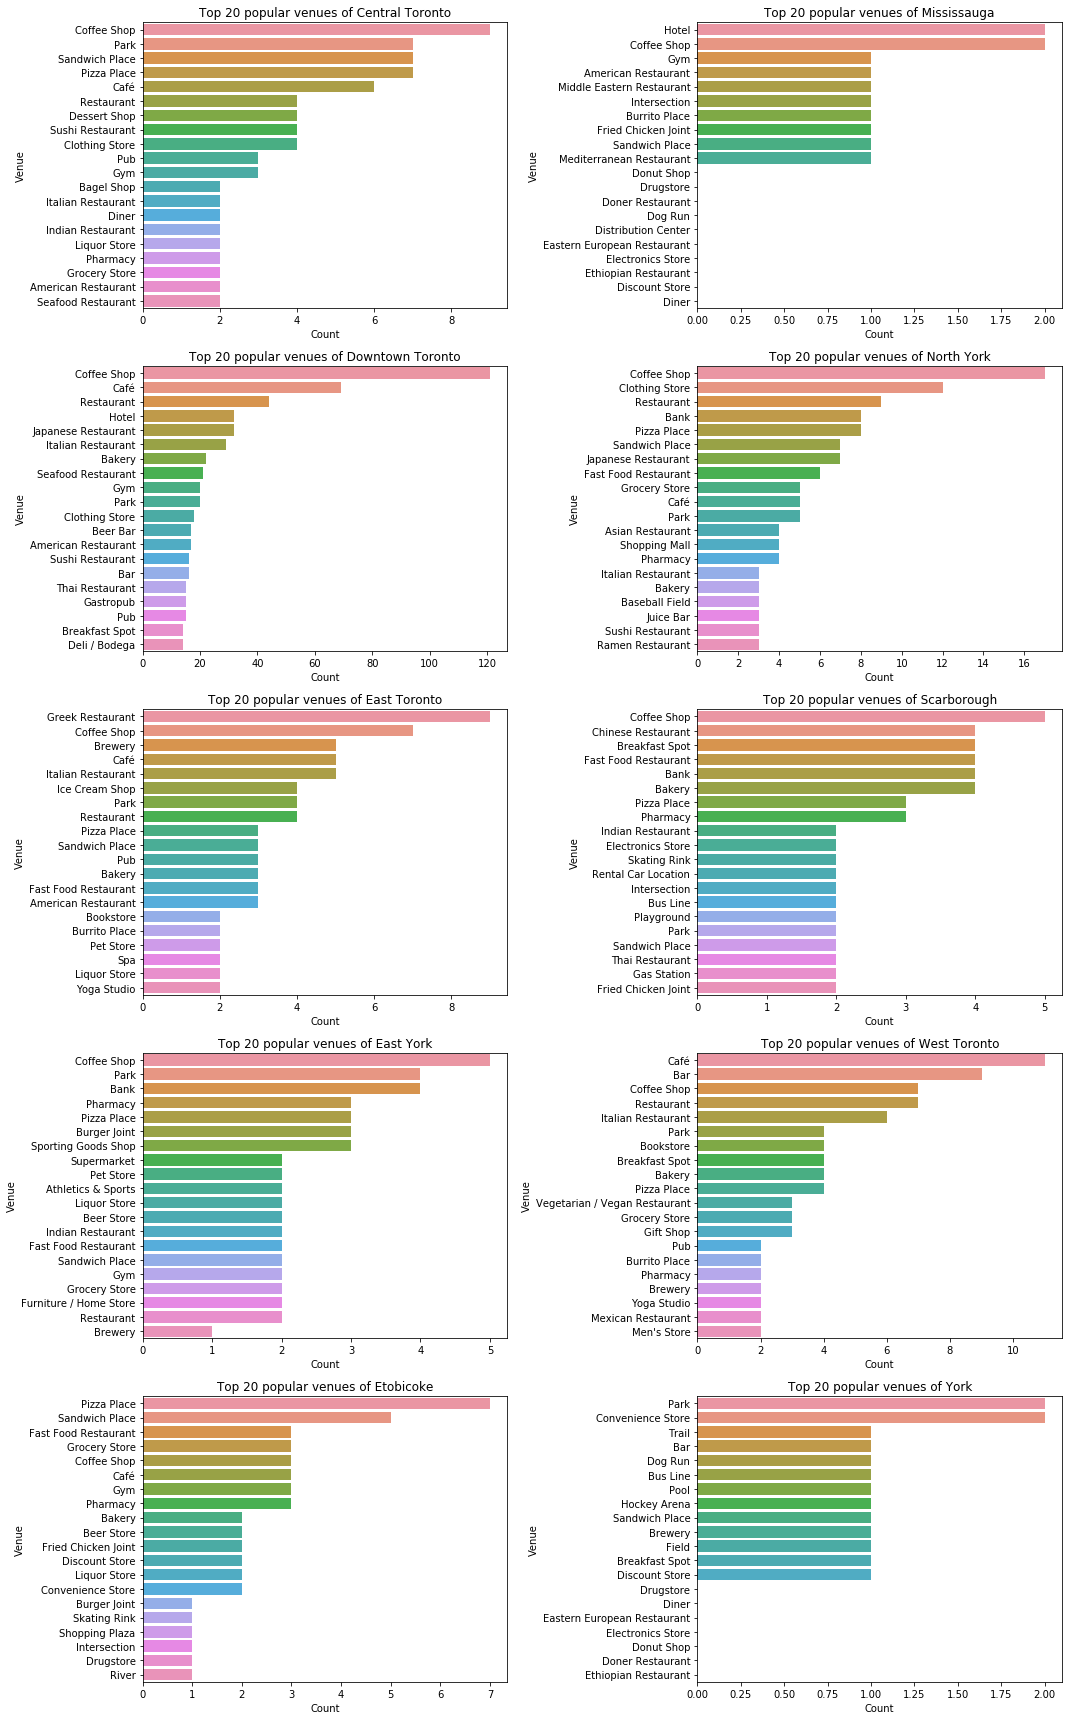

In [1069]:
#Visualizing top venues of each borough

fig, ax = plt.subplots(nrows=5, ncols=2,figsize= (15,24))
borough_list = toronto_borough.index
n = 0
m = 0 
for i in range(0,10):
    
    sns.barplot(y = "Venue", 
                x = "Count", 
                data = toronto_borough_characteristics[toronto_borough_characteristics["Borough"] == borough_list[i]], 
                ax = ax[n,m])
    ax[n,m].set_title("Top {} popular venues of {}".format(num, borough_list[i]))
    n+=1
    
    if n == 5:
        n=0
        m=1
    


plt.tight_layout()

From the plot above, it can be clearly seen that few venues almost exist in all the boroughs. These venues are coffee shops, cafe, pizza places, parks, sandwich places, pharmacy, grocery store, bakery, and gym

Pubs and bars do exist in few of the boroughs but in very less number except in Downtown Toronto

We can say that there are variety of restaurants as well very close to few of the neighborhoods and Italian restaurants are dominating in all of them

Observing the less common venues or bottom venues of the plots, we can see that all the boroughs have different  venues around such as liquor store, diner, baseball field, juice bar, pet store, spa, yoga studio, beer store, brewery, gas station, skating ring, shopping plaza etc. These venues will not be important in the final analyses part as we are just interested in more common venues which actually replicate the characteristics of that neighborhood/borough 

We can also clearly see that Downtown Toronto is tightly packed with coffee shops, cafe, pubs, bars, bakery, and variety restaurants, hotels and all other amenities. We can say that all the venues are densely located and exist in high numbers and also very close to the neighborhoods which is very common to see in the downtown of the city. The interesting thing to observe in Downtown Toronto bar plot is that the pizza place doesn't fall in top 20 venues

As the data provided in the very begining of the notebook, the boroughs have got huge land areas and that could be the reason behind less numbers of venues exist close to the neighborhoods. This leaves a great scope of developing / extending business especially in food industry like coffee shops, cafes, bars, pubs, or grocery stores

#### The plots above give the collective result of the venues around the neighborhoods exist within them but to understand the scope of opening up a business, it is necessary to observe the data of neighborhoods carefully   

## Same procedure for NYC

In [897]:
print("nyc_df has {} unique boroughs, {} unique neighborhoods, and total {} data rows".format(nyc_df["Borough"].nunique(), 
                                                                                         nyc_df["Neighborhood"].nunique(), 
                                                                                         nyc_df.shape[0])) 

nyc_df has 5 unique boroughs, 302 unique neighborhoods, and total 306 data rows


In [23]:
#Using the same function again to grab 100 venues within 500 meters of each neighborhood of NYC

nyc_venues = getNearbyVenues(borough_name=nyc_df["Borough"],
                             neighborhood_name=nyc_df['Neighborhood'],
                                   latitudes=nyc_df['Latitude'],
                                   longitudes=nyc_df['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [896]:
nyc_venues.head() #Glimpse of the Dataframe after applying the function

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Bronx    Wakefield              40.894705              -73.847201   
1   Bronx    Wakefield              40.894705              -73.847201   
2   Bronx    Wakefield              40.894705              -73.847201   
3   Bronx    Wakefield              40.894705              -73.847201   
4   Bronx    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [898]:
print("nyc_venues has {} unique neighborhoods and {} data rows".format(nyc_venues["Neighborhood"].nunique(),
                                                                       nyc_venues.shape[0])) 

nyc_venues has 301 unique neighborhoods and 9831 data rows


The main dataframe nyc_df had 302 unique neighborhoods whereas nyc_venues has 301 unique neighborhoods which indicates that we did not find any venues existing within 500 meters (0.3 miles) of radius of 1 neighborhood. Those missing neighborhood with their borough name is Howland Hook (Staten Island)

In [905]:
#Converting all the venue categories in "0's" and "1's"
#1 means that neighborhood does have that venue around it and opposite for 0

nyc_dummies = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_dummies['Borough'] = nyc_venues['Borough']
nyc_dummies['Neighborhood'] = nyc_venues['Neighborhood']


nyc_dummies.head()

Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  0               0                  0                   0   
1                  0               0                  0                   0   
2                  0               0                  0                   0   
3                  0               0                  0                   0   
4                  0               0                  0                   0   

   Airport Terminal  American Restaurant  Animal Shelter  Antique Shop  \
0                 0                    0               0             0   
1                 0                    0               0             0   
2                 0                    0               0             0   
3                 0                    0               0             0   
4                 0                    0               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   
3            0              0                0          0           0   
4            0              0                0          0           0   

   Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0           0       0     0    0               0   
1                0           0       0     0    0               0   
2                0           0       0     0    0               0   
3                0           0       0     0    0               0   
4                0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0                   0           0      0   
1                 0                 0                   0           0      0   
2                 0                 0                   0           0      0   
3                 0                 0                   0           0      0   
4                 0                 0                   0           0      0   

   Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0          0         0            0           0              0   
1          0         0            0           0              0   
2          0         0            0           0              0   
3          0         0            0           0              0   
4          0         0            0           0      

## Exploratory data analysis of borough's of NYC

In [906]:
nyc_borough = nyc_dummies.groupby("Borough").sum() #Grouping the dataframe by "Borough"
nyc_borough

Accessories Store  Adult Boutique  Afghan Restaurant  \
Borough                                                               
Bronx                          1               0                  0   
Brooklyn                       1               0                  0   
Manhattan                      1               1                  1   
Queens                         2               0                  2   
Staten Island                  2               0                  0   

               African Restaurant  Airport Terminal  American Restaurant  \
Borough                                                                    
Bronx                           3                 0                   10   
Brooklyn                        0                 1                   43   
Manhattan                       3                 0                   59   
Queens                          0                 0                   18   
Staten Island                   0                 0                   14   

               Animal Shelter  Antique Shop  Arcade  Arepa Restaurant  \
Borough                                                                 
Bronx                       0             0       1                 1   
Brooklyn                    1             7       0                 2   
Manhattan                   0             1       1                 3   
Queens                      0             0       0                 4   
Staten Island               0             0       1                 0   

               Argentinian Restaurant  Art Gallery  Art Museum  \
Borough                                                          
Bronx                               0            2           1   
Brooklyn                            2           19           0   
Manhattan                           4           33           3   
Queens                              2            2           1   
Staten Island                       0            0           1   

               Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
Borough                                                                      
Bronx                            0                     0                 6   
Brooklyn                        12                     1                12   
Manhattan                        6                     0                10   
Queens                           2                     1                13   
Staten Island                    3                     0                 3   

               Athletics & Sports  Auditorium  Australian Restaurant  \
Borough                                                                
Bronx                           2           0                      0   
Brooklyn                        5           0                      0   
Manhattan                       2           1                      4   
Queens                          3           0                      0   
Staten Island                   3           0                      0   

               Austrian Restaurant  Auto Garage  Auto Workshop  \
Borough                                                          
Bronx                            0            0              1   
Brooklyn                         0            2              0   
Manhattan                        2            0              0   
Queens                           0            0              0   
Staten Island                    0            0              0   

               Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
Borough                                                                  
Bronx                        0          3           0                0   
Brooklyn                     0          8           0                0   
Manhattan                    0          8           1                1   
Queens                       2          7           0                0   
Staten Island                0          2         

In [1120]:
num = int(input("Number of most popular venues you would like to see in each borough? "))
nyc_borough_characteristics = pd.DataFrame(columns=["Venue", "Count", "Borough"])
empty_df = pd.DataFrame()
for i in range(0,5):
    empty_df["Venue"] =  nyc_borough.iloc[i,:].iloc[0:].sort_values(ascending = False).index[0:num]
    empty_df["Count"] =  nyc_borough.iloc[i,:].iloc[0:].sort_values(ascending = False).values[0:num]
    empty_df["Borough"] = nyc_borough.index[i]
    nyc_borough_characteristics = pd.concat([nyc_borough_characteristics, empty_df], ignore_index=True)
nyc_borough_characteristics.head(num)

Number of most popular venues you would like to see in each borough? 20


Venue Count Borough
0            Pizza Place    97   Bronx
1          Deli / Bodega    57   Bronx
2             Donut Shop    44   Bronx
3               Pharmacy    43   Bronx
4     Italian Restaurant    38   Bronx
5            Bus Station    38   Bronx
6     Chinese Restaurant    37   Bronx
7         Sandwich Place    36   Bronx
8          Grocery Store    35   Bronx
9                   Bank    34   Bronx
10           Supermarket    33   Bronx
11  Fast Food Restaurant    32   Bronx
12    Spanish Restaurant    31   Bronx
13                  Park    27   Bronx
14    Mexican Restaurant    25   Bronx
15                 Diner    23   Bronx
16                Bakery    22   Bronx
17                   Bar    19   Bronx
18        Discount Store    19   Bronx
19   Fried Chicken Joint    18   Bronx

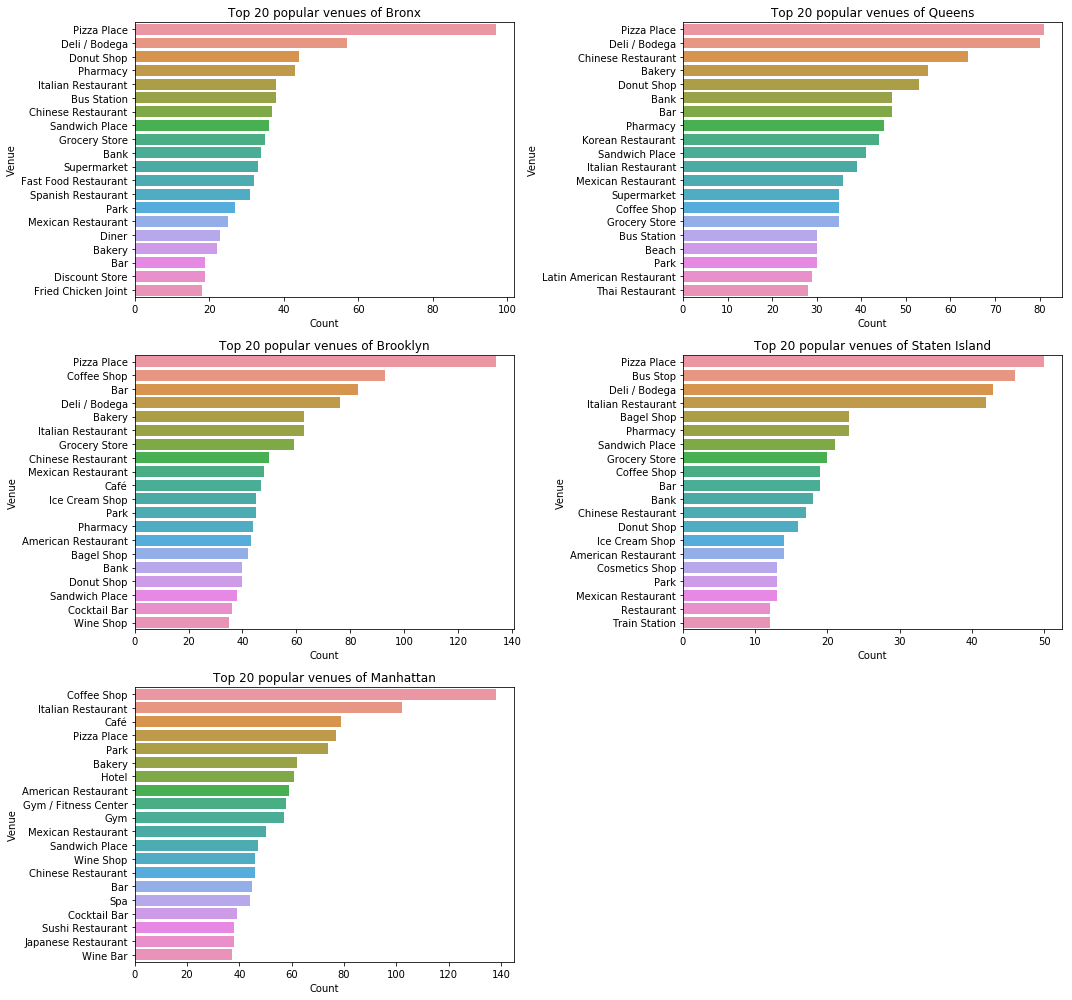

In [1121]:
#Plotting most common venues of each borough

fig, ax = plt.subplots(nrows=3, ncols=2,figsize= (15,14))
borough_list = nyc_borough.index
n = 0
m = 0 
for i in range(0,5):
    
    sns.barplot(y = "Venue", 
                x = "Count", 
                data = nyc_borough_characteristics[nyc_borough_characteristics["Borough"] == borough_list[i]], 
                ax = ax[n,m])
    ax[n,m].set_title("Top {} popular venues of {}".format(num, borough_list[i]))
    n+=1
    
    if n == 3:
        n=0
        m=1

for empty_plot_num in np.arange(nyc_borough_characteristics["Borough"].nunique(), 3*2):
    fig.delaxes(ax.flatten()[empty_plot_num])


plt.tight_layout()

From the plot above, it can be clearly seen that all the boroughs are tightly packed with plenty of pizza place, deli/bodega,  pharmacy, sandwich place, park, bar, bakery, and variety of restaurants in which Italian, Chinese, and Mexican being most popular ones

Donut shop,  grocery store, bank, bagel shop, and other restaurants are popular in all the boroughs except Manhattan
Queens has got highest variety of cuisines available including Chinese, Korean, Mexican, Italian, Latin American, and Thai  which reflects its vast cultural diversity. It has got the maximum number of beaches as well compare to any other borough

Overall, most of the boroughs have more or less similar venues except Manhattan. We can clearly see that pharmacy, bank, donut shop, bagel shop or such venues do not fall in top 20 venues of Manhattan because Manhattan downtown is considered NYC's downtown and therefore it has all the eateries and entertainment venues around the neighborhoods

#### The plots above give the collective result of the venues around the neighborhoods exist within them but to understand the scope of opening up a business, it is necessary to observe the data of neighborhoods carefully   

### Creating a dataframe which shows top 10 most popular venues of each neighborhood of both the cities

In [934]:
print("toronto_venues shape {} and number of unique neighborhoods {}".format(toronto_venues.shape, 
                                                                             toronto_venues["Neighborhood"].nunique()))
print("nyc_venues shape {} and number of unique neighborhoods {}".format(nyc_venues.shape, 
                                                                         nyc_venues["Neighborhood"].nunique()))

toronto_venues shape (2116, 8) and number of unique neighborhoods 93
nyc_venues shape (9831, 8) and number of unique neighborhoods 301


In [655]:
#Concatenating both the datframes (NYC and Toronto) with their venue details

tornyc_venues_concat = pd.concat([toronto_venues, nyc_venues], ignore_index=True)
tornyc_venues_concat.head()

Borough      Neighborhood  Neighborhood Latitude  \
0  North York         Parkwoods              43.753259   
1  North York         Parkwoods              43.753259   
2  North York  Victoria Village              43.725882   
3  North York  Victoria Village              43.725882   
4  North York  Victoria Village              43.725882   

   Neighborhood Longitude                   Venue  Venue Latitude  \
0              -79.329656         Brookbanks Park       43.751976   
1              -79.329656           Variety Store       43.751974   
2              -79.315572  Victoria Village Arena       43.723481   
3              -79.315572             Tim Hortons       43.725517   
4              -79.315572               Portugril       43.725819   

   Venue Longitude         Venue Category  
0       -79.332140                   Park  
1       -79.333114      Food & Drink Shop  
2       -79.315635           Hockey Arena  
3       -79.313103            Coffee Shop  
4       -79.312785  Portuguese Restaurant

In [656]:
print("tornyc_venues_concat shape {} and number of unique neighborhoods {}".format(tornyc_venues_concat.shape, 
                                                                                   tornyc_venues_concat["Neighborhood"].nunique()))

tornyc_venues_concat shape (11947, 8) and number of unique neighborhoods 393


In [658]:
#Converting all the venuw categories in "0's" and "1's"
#1 means that neighborhood does have that venue around it and opposite for 0

tornyc_onehot = pd.get_dummies(tornyc_venues_concat[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tornyc_onehot['Borough'] = tornyc_venues_concat['Borough']
tornyc_onehot['Neighborhood'] = tornyc_venues_concat['Neighborhood']


tornyc_onehot.head(3)

Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  0               0                  0                   0   
1                  0               0                  0                   0   
2                  0               0                  0                   0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0        0                   0               0                0   
1        0                   0               0                0   
2        0                   0               0                0   

   Airport Terminal  American Restaurant  Animal Shelter  Antique Shop  \
0                 0                    0               0             0   
1                 0                    0               0             0   
2                 0                    0               0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       0                 0                       0            0   
2         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   

   Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0           0       0     0    0               0   
1                0           0       0     0    0               0   
2                0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0                   0           0      0   
1                 0                 0                   0           0      0   
2                 0                 0                   0           0      0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0                0         0            0           0   
1          0                0         0            0           0   
2          0                0         0            0           0   

   Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  Bike Shop  \
0                   0              0                         0          0   
1                   0              0                         0          0   
2                   0              0                         0          0   

   Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0           0       0           0              0          0         0   
1           0       0           0              0          0         0   
2           0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   

   Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0          

In [935]:
print("tornyc_onehot shape {}, number of unique venue categories {}, and number of unique neighborhoods {} ".format(
                                                                                   tornyc_onehot.shape, 
                                                                                   tornyc_onehot.shape[1]-2,
                                                                                   tornyc_onehot["Neighborhood"].nunique()))

tornyc_onehot shape (11947, 462), number of unique venue categories 460, and number of unique neighborhoods 393 


In [663]:
#Grouping the data by "Neighborhood" using sum() to get the popular venues of each neighborhood

tornyc_grouped = tornyc_onehot.groupby(["Borough","Neighborhood"]).sum().reset_index()
tornyc_grouped.head(3)

Borough  Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0   Bronx      Allerton                  0               0                  0   
1   Bronx    Baychester                  0               0                  0   
2   Bronx  Bedford Park                  0               0                  0   

   African Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                   0        0                   0               0   
1                   0        0                   0               0   
2                   0        0                   0               0   

   Airport Service  Airport Terminal  American Restaurant  Animal Shelter  \
0                0                 0                    0               0   
1                0                 0                    0               0   
2                0                 0                    0               0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 0                       0   
1             0         0       1                 0                       0   
2             0         0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   

   Austrian Restaurant  Auto Garage  Auto Workshop  Automotive Shop  \
0                    0            0              0                0   
1                    0            0              0                0   
2                    0            0              0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          0           0                0           0       0     0    0   
1          0           0                0           0       0     1    0   
2          0           0                0           0       0     0    1   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0           0      0          0                0         0            0   
1           0      0          0                0         0            0   
2           0      0          0                0         0            0   

   Beer Store  Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  \
0           0                   0              0                         0   
1           0                   0              0                         0   
2           0                   0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0          0           0       0           0              0          0   
1          0           0       0           0              1          0   
2          0           0       0           0              0          0   

   Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  \
0         0              0           0                     0               1   
1         0              0           0                     0               0   
2         0              0           0                     0               0   

   Brewery  Bridal Shop  Bridge  

In [671]:
print("tornyc_grouped shape {}, number of unique venue categories {}, and number of unique neighborhoods {} ".format(
                                                                                   tornyc_grouped.shape, 
                                                                                   tornyc_grouped.shape[1] - 2,
                                                                                   tornyc_grouped["Neighborhood"].nunique()))

tornyc_grouped shape (398, 462), number of unique venue categories 460, and number of unique neighborhoods 393 


In [666]:
# function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [667]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ["Borough", "Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tornyc_popular_venues = pd.DataFrame(columns=columns)
tornyc_popular_venues['Borough'] = tornyc_grouped['Borough']
tornyc_popular_venues['Neighborhood'] = tornyc_grouped['Neighborhood']

for ind in np.arange(tornyc_grouped.shape[0]):
    tornyc_popular_venues.iloc[ind, 2:] = return_most_common_venues(tornyc_grouped.iloc[ind, :], num_top_venues)

tornyc_popular_venues.head(3)

Borough  Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Bronx      Allerton           Pizza Place         Deli / Bodega   
1   Bronx    Baychester            Donut Shop    Mexican Restaurant   
2   Bronx  Bedford Park    Chinese Restaurant                 Diner   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Grocery Store           Supermarket        Cosmetics Shop   
1         Boat or Ferry                  Bank        Mattress Store   
2           Pizza Place    Mexican Restaurant         Deli / Bodega   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Martial Arts Dojo    Chinese Restaurant            Donut Shop   
1        Sandwich Place            Laundromat           Men's Store   
2           Supermarket    Spanish Restaurant        Sandwich Place   

   9th Most Common Venue 10th Most Common Venue  
0  Check Cashing Service            Gas Station  
1         Discount Store              Pet Store  
2            Bus Station         Discount Store

### From the dataframe above "tornyc_popular_venues" top 10 venues of each neighborhood of a particular borough can be analysed

## Application of K-Means Clustering

In [670]:
#Copying the main "tornyc_grouped" dataframe to another dataframe on which k means clustering will be implemented

tornyc_cluster = tornyc_grouped.copy()
tornyc_cluster.drop(["Borough", "Neighborhood"], axis =1, inplace = True)
tornyc_cluster.head(3)

Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  0               0                  0                   0   
1                  0               0                  0                   0   
2                  0               0                  0                   0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0        0                   0               0                0   
1        0                   0               0                0   
2        0                   0               0                0   

   Airport Terminal  American Restaurant  Animal Shelter  Antique Shop  \
0                 0                    0               0             0   
1                 0                    0               0             0   
2                 0                    0               0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       1                 0                       0            0   
2         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   

   Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0           0       0     0    0               0   
1                0           0       0     1    0               0   
2                0           0       0     0    1               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0                   0           0      0   
1                 0                 0                   0           0      0   
2                 0                 0                   0           0      0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0                0         0            0           0   
1          0                0         0            0           0   
2          0                0         0            0           0   

   Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  Bike Shop  \
0                   0              0                         0          0   
1                   0              0                         0          0   
2                   0              0                         0          0   

   Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0           0       0           0              0          0         0   
1           0       0           0              1          0         0   
2           0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               1        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   

   Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0          

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters (Elbow Method)')

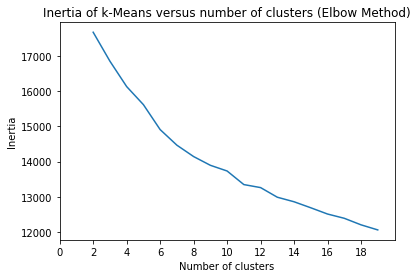

In [676]:
#Plotting the inertia for different values of clusters from 2 to 20

scores = [KMeans(init="k-means++", n_clusters= i+2, n_init= 12, random_state=0).fit(tornyc_cluster).inertia_ 
          for i in range(18)]
sns.lineplot(np.arange(2, 20),scores)
plt.xlim(0,20)
plt.xticks(np.arange(0,20,2))
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters (Elbow Method)")

The resultant plot to find the best value of k is shown above. Inertia is the sum of squared error for each cluster. Therefore, the smaller the inertia the denser the cluster (closer together all the points are). As we can clearly see in the plot that there is no elbow effect taking place at any point from where the inertia stops decreasing drastically.  

In [615]:
#Higher the silhoutte_score better the clustering gets done

from sklearn.metrics import silhouette_score

In [675]:
for kclusters in range(2,20):

    # run k-means clustering
    kmeans = KMeans(init="k-means++", n_clusters= kclusters, n_init=12, random_state=0).fit(tornyc_cluster)

    # check silhouette_score to select the best number of clusters
    print('Silhouette score for {} clusters is {}'.format(kclusters,silhouette_score(tornyc_cluster, kmeans.labels_, 
                                           metric='euclidean')))

Silhouette score for 2 clusters is 0.4034283805167753
Silhouette score for 3 clusters is 0.40349362532200234
Silhouette score for 4 clusters is 0.19087266036727923
Silhouette score for 5 clusters is 0.17453108251512764
Silhouette score for 6 clusters is 0.19042137124538644
Silhouette score for 7 clusters is 0.1806174854345083
Silhouette score for 8 clusters is 0.16508282125106924
Silhouette score for 9 clusters is 0.15074062565335905
Silhouette score for 10 clusters is 0.15751853826117035
Silhouette score for 11 clusters is 0.16279966412506686
Silhouette score for 12 clusters is 0.1726859685665183
Silhouette score for 13 clusters is 0.1547449487069044
Silhouette score for 14 clusters is 0.14883655049153663
Silhouette score for 15 clusters is 0.13180280923521728
Silhouette score for 16 clusters is 0.10139488448851307
Silhouette score for 17 clusters is 0.15813177063875258
Silhouette score for 18 clusters is 0.11795409869789909
Silhouette score for 19 clusters is 0.10054022139688085


Even Silhouette score did not help to reach to any conclusion as we can see from the results above. The Silhouette Score is from -1 to 1 and show how close or far away the clusters are from each other and how dense the clusters are. The closer your silhouette score is to 1 the more distinct your clusters are. It is around 0.4 for k = 2 and k = 3 but using those values wouldn’t let us examine the characteristics of the clusters properly

#### So after trying different k value from 2 to 20 and observing the distribution of the cluster labels, I chose number of clusters to be 9. Optimizing the clusters by trying different k values stands out as a scope of future analysis  

In [1014]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters= kclusters, n_init=12, random_state=0).fit(tornyc_cluster)

# check distribution of values in different clusters
print(pd.DataFrame(kmeans.labels_)[0].value_counts())
print("Total number of labels generated: {}".format(len(kmeans.labels_)))

1    220
0     85
3     39
7     16
5     14
8     11
2     10
4      2
6      1
Name: 0, dtype: int64
Total number of labels generated: 398


In [1021]:
# adding clustering labels or Replacing clustering labels

#tornyc_popular_venues.insert(1, 'Cluster Labels', kmeans.labels_) #To insert new cluster label column if needed 
tornyc_popular_venues['Cluster Labels'] = kmeans.labels_

merged_df = tornyc_concat.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged_df = merged_df.join(tornyc_popular_venues.set_index('Neighborhood'), on='Neighborhood', lsuffix = "_Left", rsuffix="_Right")
merged_df.dropna(inplace = True)
merged_df["Cluster Labels"] = merged_df["Cluster Labels"].astype(int)
#nyork_merged.drop(" New Cluster Labels", axis=1, inplace = True)
merged_df.head(2)

Borough_Left      Neighborhood   Latitude  Longitude Borough_Right  \
0   North York         Parkwoods  43.753259 -79.329656    North York   
1   North York  Victoria Village  43.725882 -79.315572    North York   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               1     Food & Drink Shop                  Park   
1               1     French Restaurant           Coffee Shop   

        3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0                 Yoga Studio               Exhibit    Dumpling Restaurant   
1  Financial or Legal Service          Intersection  Portuguese Restaurant   

  6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
0        Duty-free Shop  Eastern European Restaurant   Egyptian Restaurant   
1          Hockey Arena          Empanada Restaurant  Ethiopian Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0      Electronics Store    Empanada Restaurant  
1  Entertainment Service     English Restaurant

Removing all the duplicate index which may have created because of Join operation

In [1023]:
merged_df.reset_index(inplace=True)

In [1026]:
merged_df.drop(labels=[88, 215, 217, 242, 271, 279, 284, 325, 341, 351], inplace = True)

In [1027]:
merged_df.set_index("index", inplace = True)

In [1028]:
merged_df.shape

(403, 16)

### "merged_df"  dataframe will be used as a main dataframe which contains all the neighborhood and borough data with their locations and the clusters they fall under

#### Extracting data out of merged_df and creating a seperate dataframe for Toronto boroughs and neighborhoods 

In [1029]:
TORONTO_MAP = pd.DataFrame()

for boroughs in toronto_borough_list:
    TORONTO_MAP = TORONTO_MAP.append(merged_df[merged_df["Borough_Left"] == boroughs],
                                                                       ignore_index = True)
TORONTO_MAP.head()

Borough_Left              Neighborhood   Latitude  Longitude  \
0  Central Toronto             Lawrence Park  43.728020 -79.388790   
1  Central Toronto                  Roselawn  43.711695 -79.416936   
2  Central Toronto          Davisville North  43.712751 -79.390197   
3  Central Toronto  Forest Hill North & West  43.696948 -79.411307   
4  Central Toronto        North Toronto West  43.715383 -79.405678   

     Borough_Right  Cluster Labels    1st Most Common Venue  \
0  Central Toronto               1                     Park   
1  Central Toronto               1  Health & Beauty Service   
2  Central Toronto               1                      Gym   
3  Central Toronto               1                    Trail   
4  Central Toronto               1           Clothing Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Swim School              Bus Line               Exhibit   
1                Garden           Yoga Studio               Exhibit   
2                  Park     Food & Drink Shop        Breakfast Spot   
3      Sushi Restaurant                  Park         Jewelry Store   
4           Coffee Shop           Yoga Studio  Fast Food Restaurant   

  5th Most Common Venue  6th Most Common Venue        7th Most Common Venue  \
0   Dumpling Restaurant         Duty-free Shop  Eastern European Restaurant   
1   Dumpling Restaurant         Duty-free Shop  Eastern European Restaurant   
2      Department Store                  Hotel               Sandwich Place   
3  Ethiopian Restaurant  Entertainment Service           English Restaurant   
4    Salon / Barbershop                   Park                Grocery Store   

  8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0   Egyptian Restaurant      Electronics Store    Empanada Restaurant  
1   Egyptian Restaurant      Electronics Store    Empanada Restaurant  
2   Empanada Restaurant  Entertainment Service     English Restaurant  
3   Empanada Restaurant            Yoga Studio            Event Space  
4    Chinese Restaurant             Bagel Shop              Pet Store

In [1088]:
#Lat and Long of Toronto

latitude = 43.6534817
longitude = -79.3839347

# create map of different clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(TORONTO_MAP["Latitude"], TORONTO_MAP["Longitude"], 
                                  TORONTO_MAP["Borough_Left"], TORONTO_MAP['Neighborhood'], TORONTO_MAP['Cluster Labels']):
    label = folium.Popup(str("(" + bor + ")") + "\n" + str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

From the plot above, it can be clearly observed that most of the neighborhoods of Toronto fall under cluster 1 (violet circles) and the few of the remaining neighborhoods fall under 2-3 different clusters. We can clearly see that the downtown area that is Downtown Toronto show different characteristics than the other neighborhoods of Toronto. We can now analyse the data of these different clusters and understand the characteristics of these neighborhoods  

In [1086]:
TORONTO_MAP["Cluster Labels"].value_counts()

1    72
7    13
3     9
0     4
Name: Cluster Labels, dtype: int64

In [1031]:
#tornyc_grouped.insert(2, 'Cluster Labels', kmeans.labels_) #To insert the cluster labels if needed
tornyc_grouped["Cluster Labels"] = kmeans.labels_
tornyc_grouped.head()

Borough  Neighborhood  Cluster Labels  Accessories Store  Adult Boutique  \
0   Bronx      Allerton               0                  0               0   
1   Bronx    Baychester               1                  0               0   
2   Bronx  Bedford Park               0                  0               0   
3   Bronx       Belmont               2                  0               0   
4   Bronx     Bronxdale               1                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   
3                  0                   0        0                   0   
4                  0                   0        0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    1   
4               0                0                 0                    0   

   Animal Shelter  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0               0             0         0       0                 0   
1               0             0         0       1                 0   
2               0             0         0       0                 0   
3               0             0         0       0                 0   
4               0             0         0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                     0                 0                   0           0   
1                     0                 0                   0           0   
2                     0                 0                   0           0   
3                     0                 0                   0           0   
4                     0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   
3                      0                    0            0              0   
4                      0                    0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Badminton Court  Bagel Shop  \
0                0          0           0                0           0   
1                0          0           0                0           0   
2                0          0           0                0           0   
3                0          0           0                0           0   
4                0          0           0                0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     1    0               0                 0                 0   
2       0     0    1               0                 0                 0   
3       5     3    2               0                 0                 0   
4 

In [1032]:
#Creating a dataframe which will help to understand the characteristics of the different neighborhoods

TORONTO_CLUSTERS_CHARACTERISTICS = pd.DataFrame()

for boroughs in toronto_borough_list:
    TORONTO_CLUSTERS_CHARACTERISTICS = TORONTO_CLUSTERS_CHARACTERISTICS.append(
                                                                        tornyc_grouped[tornyc_grouped["Borough"] == boroughs],
                                                                        ignore_index = True)
TORONTO_CLUSTERS_CHARACTERISTICS = TORONTO_CLUSTERS_CHARACTERISTICS.groupby("Cluster Labels").sum().reset_index()
TORONTO_CLUSTERS_CHARACTERISTICS

Cluster Labels  Accessories Store  Adult Boutique  Afghan Restaurant  \
0               0                  0               0                  0   
1               1                  1               0                  0   
2               3                  0               0                  0   
3               7                  0               0                  1   

   African Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                   0        0                   0               0   
1                   0        2                   1               2   
2                   0        0                   0               0   
3                   0        0                   0               0   

   Airport Service  Airport Terminal  American Restaurant  Animal Shelter  \
0                0                 0                    0               0   
1                2                 2                    6               0   
2                0                 0                    3               0   
3                0                 0                   18               0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 0                       0   
1             0         0       0                 0                       0   
2             0         0       0                 0                       0   
3             2         5       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    1                     0   
1            0           0                    1                     0   
2            2           0                    2                     0   
3           11           2                    2                     0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 3                   5           0                      0   
2                 2                   0           0                      0   
3                10                   0           0                      0   

   Austrian Restaurant  Auto Garage  Auto Workshop  Automotive Shop  \
0                    0            0              0                0   
1                    0            1              1                0   
2                    0            0              0                0   
3                    0            0              0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          0           0                0           0       0     4    0   
1          1           1                0           3      11    12   10   
2          1           0                0           1      12     4   11   
3          2           0                0           1      15     7   12   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               3                 0                 1                   0   
2               0                 0                 0                   1   
3               1                 2                 0                   3   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0           0      0          0                0         0            0   
1           0      0          0                0         0            0   
2           0      1          0                1         3            0   
3           0      0          0                0        14            0   

   Beer Store  Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  \
0           0                   0              0                         0   
1           6                   0              0                         0   
2   

### Similar steps to extract, analyse, and visualize the data for NYC boroughs and neighborhoods

#### Extracting data out of merged_df and creating a seperate dataframe for NYC boroughs and neighborhoods

In [1034]:
NYC_MAP = pd.DataFrame()

for boroughs in nyc_borough_list:
    NYC_MAP = NYC_MAP.append(merged_df[merged_df["Borough_Left"] == boroughs],
                                                                       ignore_index = True)
NYC_MAP.head()

Borough_Left Neighborhood   Latitude  Longitude Borough_Right  \
0        Bronx    Wakefield  40.894705 -73.847201         Bronx   
1        Bronx   Co-op City  40.874294 -73.829939         Bronx   
2        Bronx  Eastchester  40.887556 -73.827806         Bronx   
3        Bronx    Fieldston  40.895437 -73.905643         Bronx   
4        Bronx    Riverdale  40.890834 -73.912585         Bronx   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               1              Pharmacy        Ice Cream Shop   
1               1           Bus Station          Liquor Store   
2               1  Caribbean Restaurant              Bus Stop   
3               1                 Plaza  Medical Supply Store   
4               1                  Park           Bus Station   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Dessert Shop            Donut Shop            Laundromat   
1           Pizza Place                  Park            Bagel Shop   
2                 Diner           Bus Station         Deli / Bodega   
3                 River           Bus Station           Yoga Studio   
4                 Plaza                  Bank        Baseball Field   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0        Sandwich Place           Gas Station        Farmers Market   
1         Grocery Store    Chinese Restaurant        Mattress Store   
2           Pizza Place    Chinese Restaurant            Donut Shop   
3           Event Space   Dumpling Restaurant        Duty-free Shop   
4          Home Service                   Gym            Food Truck   

         9th Most Common Venue 10th Most Common Venue  
0           English Restaurant      Fish & Chips Shop  
1                     Pharmacy         Discount Store  
2                Metro Station              Juice Bar  
3  Eastern European Restaurant    Egyptian Restaurant  
4         Fast Food Restaurant   Ethiopian Restaurant

In [1035]:
#Lat and Long of NYC

latitude = 40.7127281
longitude = -74.0060152

# create map of different clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, poi, cluster in zip(NYC_MAP["Latitude"], NYC_MAP["Longitude"], 
                                  NYC_MAP["Borough_Left"], NYC_MAP['Neighborhood'], NYC_MAP['Cluster Labels']):
    label = folium.Popup(str("(" + bor + ")") + "\n" + str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

From the plot above, it can be clearly observed that most of the neighborhoods of NYC fall under cluster 1 (violet circles). There are so many other neighborhoods which fall under cluster 0 (red circles) and the remaining neighborhoods are distributed under different clusters. We can clearly see that the downtown area that is lower Manhattan show different characteristics than the other neighborhoods of NYC

In [1087]:
NYC_MAP["Cluster Labels"].value_counts()

1    152
0     82
3     30
5     14
8     11
2     10
7      3
4      2
6      1
Name: Cluster Labels, dtype: int64

In [1036]:
NYC_CLUSTERS_CHARACTERISTICS = pd.DataFrame()

for boroughs in nyc_borough_list:
    NYC_CLUSTERS_CHARACTERISTICS = NYC_CLUSTERS_CHARACTERISTICS.append(tornyc_grouped[tornyc_grouped["Borough"] == boroughs],
                                                                       ignore_index = True)
NYC_CLUSTERS_CHARACTERISTICS = NYC_CLUSTERS_CHARACTERISTICS.groupby("Cluster Labels").sum().reset_index()
NYC_CLUSTERS_CHARACTERISTICS

Cluster Labels  Accessories Store  Adult Boutique  Afghan Restaurant  \
0               0                  3               0                  0   
1               1                  2               0                  2   
2               2                  0               0                  1   
3               3                  2               0                  0   
4               4                  0               0                  0   
5               5                  0               1                  0   
6               6                  0               0                  0   
7               7                  0               0                  0   
8               8                  0               0                  0   

   African Restaurant  Airport  Airport Food Court  Airport Lounge  \
0                   3        0                   0               0   
1                   3        0                   0               0   
2                   0        0                   0               0   
3                   0        0                   0               0   
4                   0        0                   0               0   
5                   0        0                   0               0   
6                   0        0                   0               0   
7                   0        0                   0               0   
8                   0        0                   0               0   

   Airport Service  Airport Terminal  American Restaurant  Animal Shelter  \
0                0                 0                   21               0   
1                0                 1                   20               0   
2                0                 0                    6               0   
3                0                 0                   33               0   
4                0                 0                    2               0   
5                0                 0                   32               0   
6                0                 0                    3               0   
7                0                 0                    5               0   
8                0                 0                   22               1   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 4                       0   
1             2         0       2                 0                       1   
2             0         0       1                 1                       2   
3             2         0       0                 1                       3   
4             0         0       0                 0                       0   
5             3         0       0                 0                       1   
6             0         0       0                 0                       0   
7             0         0       0                 0                       0   
8             1         0       0                 4                       1   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            2           1                    0                     0   
1            5           1                    7                     0   
2            6           1                    3                     0   
3            9           0                    7                     0   
4            0           0                    0                     0   
5           11           2                    3                     0   
6           16           0                    0                     0   
7            1           1                    0                     1   
8            6           0                    3                     1   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                13                   1           0                      0   
1                 9                   8           0                      0   
2                 5     

## Similarities of neighborhoods of NYC and TORONTO

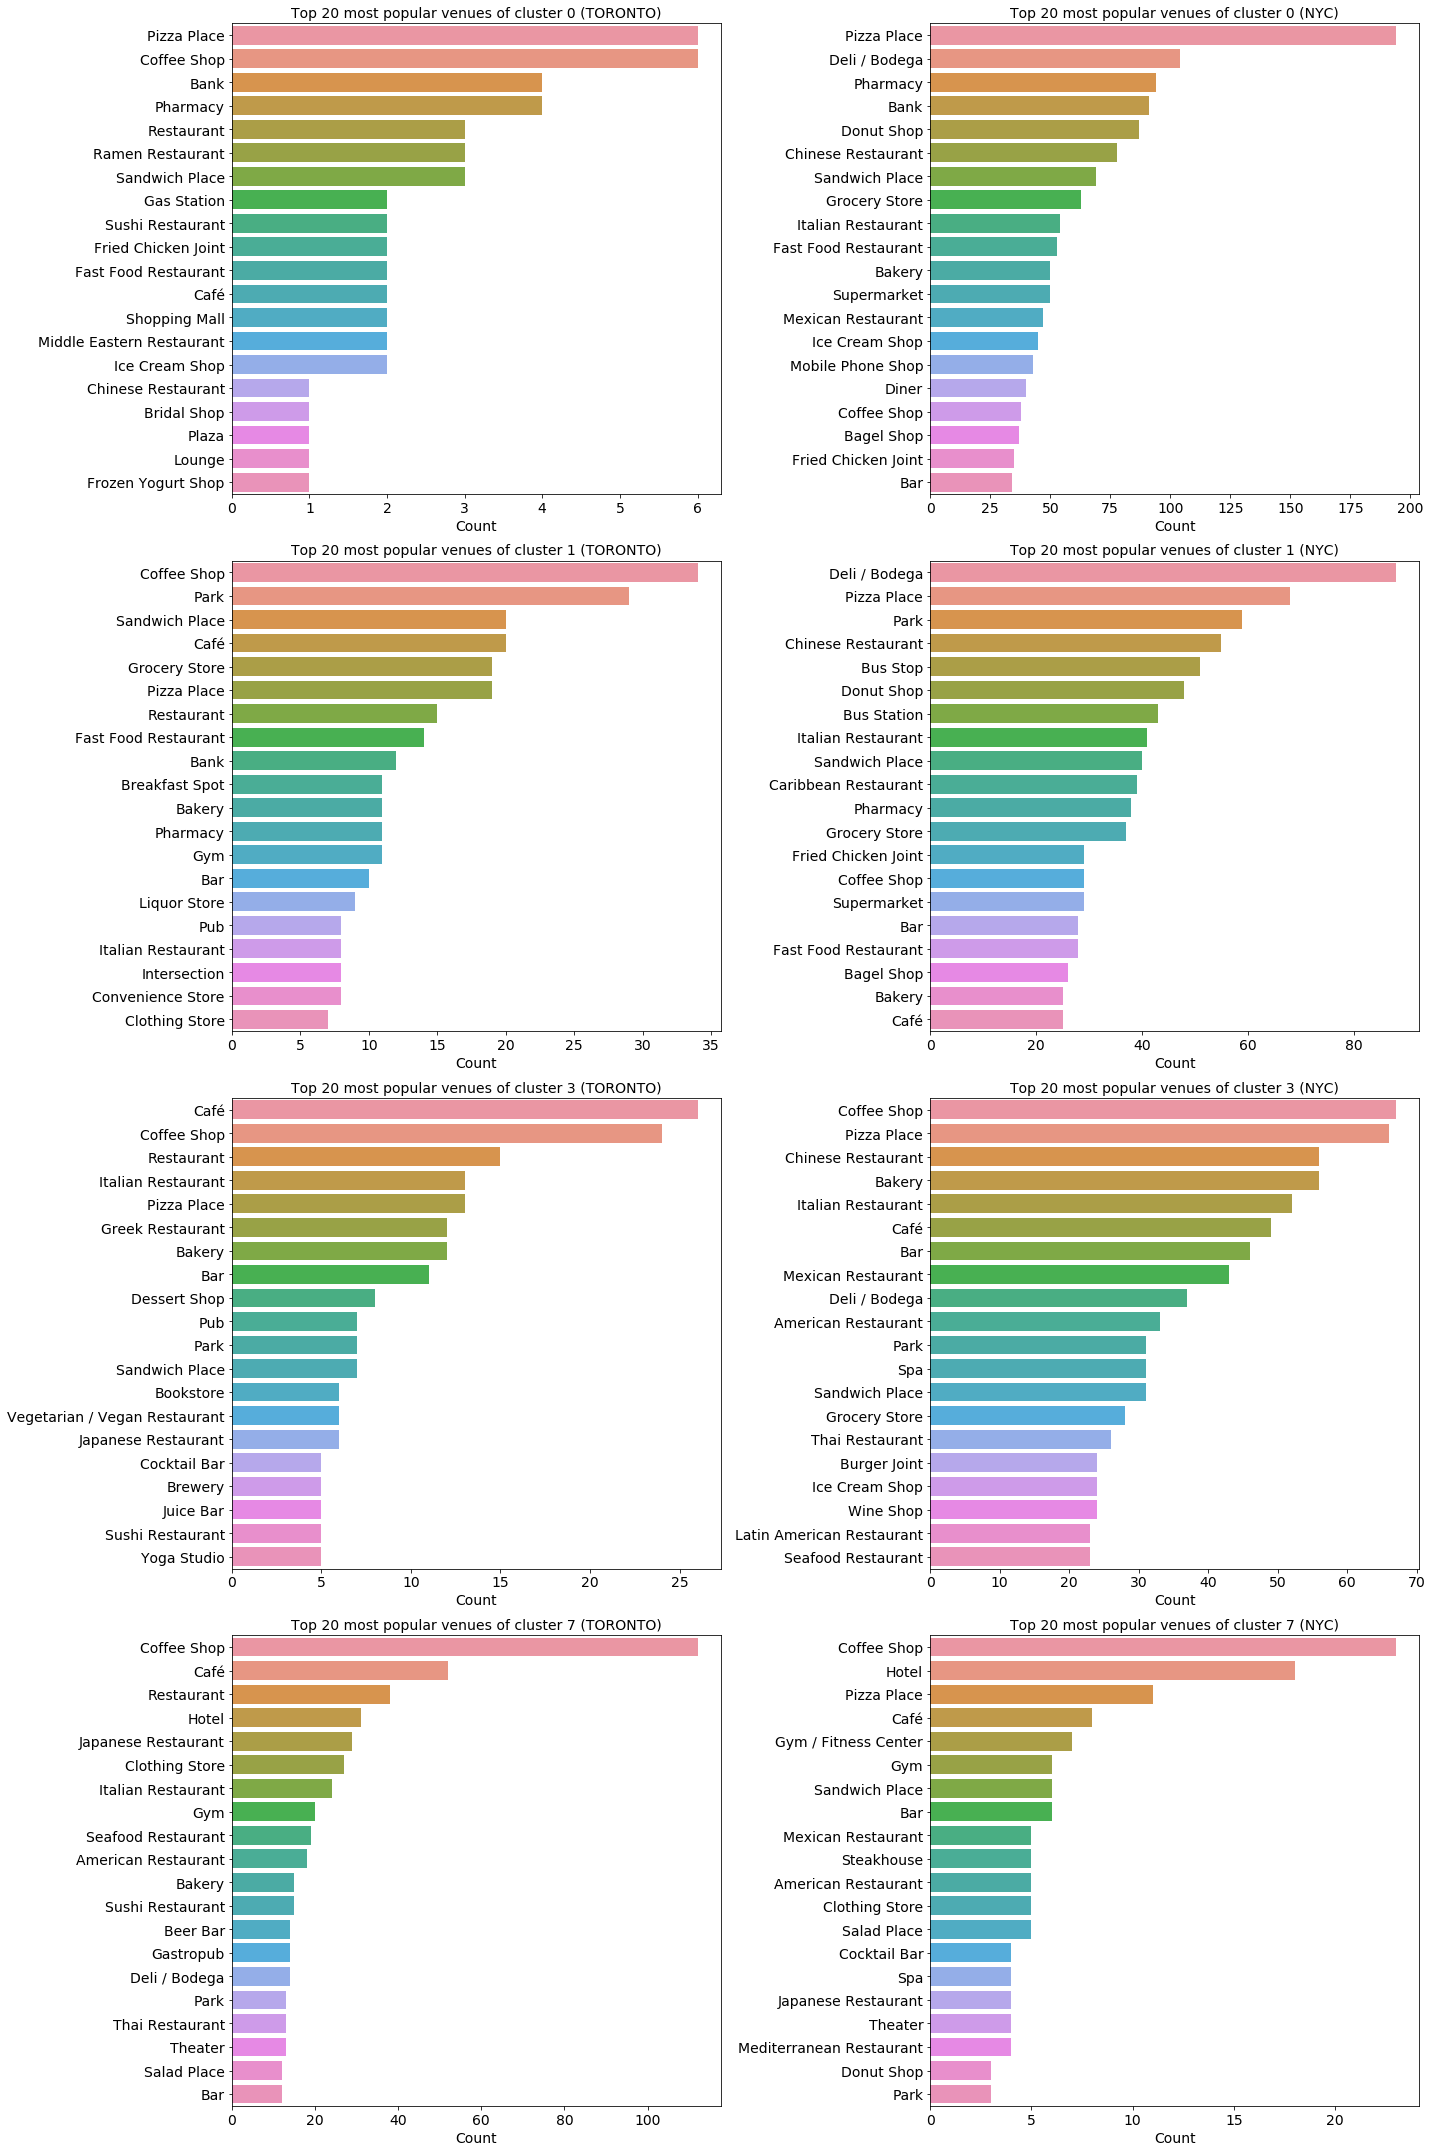

In [1123]:
num = 20
fig, ax = plt.subplots(nrows=4, ncols=2,figsize= (20,30))
n = 0
m = 0 
for i in range(0,len(TORONTO_CLUSTERS_CHARACTERISTICS)):
    
    sns.barplot(y = TORONTO_CLUSTERS_CHARACTERISTICS.iloc[i,1:].sort_values(ascending = False).head(num).index, 
                x = TORONTO_CLUSTERS_CHARACTERISTICS.iloc[i,1:].sort_values(ascending = False).head(num).values, 
                ax = ax[n,m])
    ax[n,m].set_title("Top {} most popular venues of cluster {} (TORONTO)".format(num,
                                                                        TORONTO_CLUSTERS_CHARACTERISTICS["Cluster Labels"][i]),
                                                                        fontsize=14)
    
    ax[n,m].tick_params(axis='y', labelsize=14)
    ax[n,m].tick_params(axis='x', labelsize=14)
    ax[n,m].set_xlabel("Count", fontsize=14)
    n+=1
    
    if n == 4:
        n=0
        m=1
        
        for j in [0,1,3,7]:
            sns.barplot(y = NYC_CLUSTERS_CHARACTERISTICS.iloc[j,1:].sort_values(ascending = False).head(num).index, 
                        x = NYC_CLUSTERS_CHARACTERISTICS.iloc[j,1:].sort_values(ascending = False).head(num).values, 
                        ax = ax[n,m])
            ax[n,m].set_title("Top {} most popular venues of cluster {} (NYC)".format(num,
                                                                        NYC_CLUSTERS_CHARACTERISTICS["Cluster Labels"][j]), 
                                                                        fontsize=14)
            ax[n,m].tick_params(axis='y', labelsize=14)
            ax[n,m].tick_params(axis='x', labelsize=14)
            ax[n,m].set_xlabel("Count", fontsize=14)
            n+=1


plt.tight_layout()

Observing each cluster seperately, we can see that Cluster 0 (Toronto) and Cluster 0 (NYC) has multiple venues exactly same such as pizza place, coffee shop, bank, pharmacy, fast food restaurant, chinese restaurant, sandwich place, and ice cream shops. It can be seen clearly that the number of total venues exist around the neighborhoods of Toronto would be pretty low as the collective values (sum of all the venues exist in cluster 0 ) of the venues are not even reaching double digits. 

Similarly, Cluster 1 (Toronto) and Cluster 1 (NYC) share common venues such as coffee shop, park, sandwich place, cafe, grocery store, pizza place, fast food restaurant, bakery, pharmacy, bar, and Italian restaurants

Cluster 3 (Toronto) and Cluster 3 (NYC) have cafe, coffee shop, Italian restaurant, pizza place, bakery, bar, park, sandwich place in common

Cluster 7 (Toronto) and Cluster 7 (NYC) share common venues such as coffee shop, cafe, hotel, Japanese restaurant, clothing store, gym, American restaurant, park, salad place, bar

We can clearly observe that different cluster that is cluster 0, 1, 3, and 7 have different venues at least out of top 20 venues with different top most venues as well as bottommost venues which proves that clustering performed pretty well. 

The other thing is the venues of Toronto and NYC falling under same cluster do share at least 7-8 venues exactly same which again proves that clustering is performed well and these neighborhoods/ boroughs do have similar characteristics in terms of venues around them

Even falling under the same clusters the only difference is the number of venues. NYC has got plenty of venues surrounding the neighborhoods where as Toronto have the venues little farther from the location of the neighborhoods. It is quite clear from the population data and the sq miles of boroughs that NYC is very tightly packed with people within very small areas which might make travelling impossible and that eventually leads to open up all the possible businesses around the neighborhood only

## Dissimilarities of neighborhoods of NYC and TORONTO

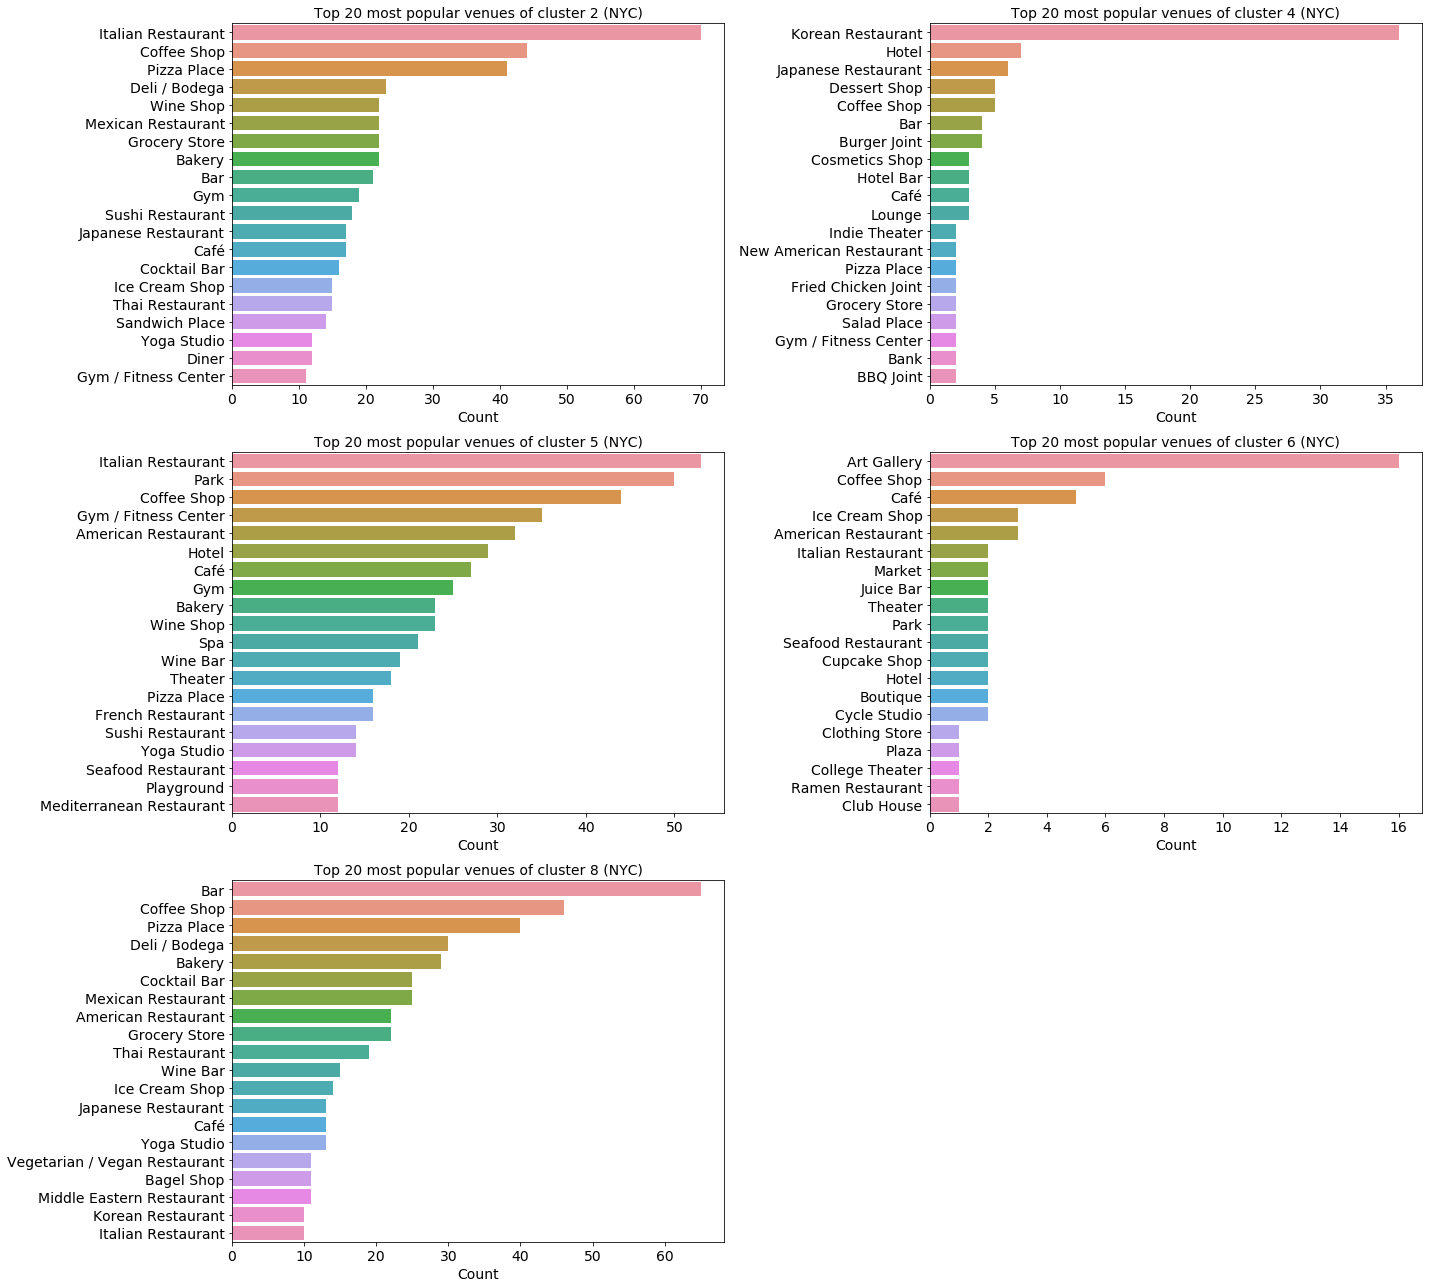

In [1308]:
num = 20
fig, ax = plt.subplots(nrows=3, ncols=2,figsize= (20,18))
n = 0
m = 0
for j in [2,4,5,6,8]:
            sns.barplot(y = NYC_CLUSTERS_CHARACTERISTICS.iloc[j,1:].sort_values(ascending = False).head(num).index, 
                        x = NYC_CLUSTERS_CHARACTERISTICS.iloc[j,1:].sort_values(ascending = False).head(num).values, 
                        ax = ax[n,m])
            ax[n,m].set_title("Top {} most popular venues of cluster {} (NYC)".format(num,
                                                                        NYC_CLUSTERS_CHARACTERISTICS["Cluster Labels"][j]), 
                                                                        fontsize=14)
            ax[n,m].tick_params(axis='y', labelsize=14)
            ax[n,m].tick_params(axis='x', labelsize=14)
            ax[n,m].set_xlabel("Count", fontsize=14)
            
            m=m+1
            
            if m == 2:
                n=n+1
                m=0
                
for empty_plot_num in np.arange(5, 3*2):
    fig.delaxes(ax.flatten()[empty_plot_num])



    plt.tight_layout()

It is very clear that none of the neighborhoods of Toronto fall under clusters 2, 4, 5, 6, or 8 which means that the neighborhoods falling under these clusters show little or more difference in their surroundings comapre to the neighborhoods of Toronto

There are two neighborhoods under cluster 4 and just one neighborhood under cluster 6 which have different characteristics than any other neighborhoods of NYC itself so they had to be different than the neighborhoods of Toronto as well. These two clusters have Art galleries, Korean restaurants, dessert shops, cosmetics shops, juice shops, cupcake shops, plazas, lounges around their neighborhoods. Each of these neighborhoods are analysed in details later in the notebook

Cluster 8 definitely has top most common venues similar to some of the neighborhoods of Toronto such as bar, coffee shops, and pizza places but other than that the most common venues include various different types of restaurants such as Mexican, American, Thai, Japanese, Vegan, Korean, Middle Eastern, and Italian. Along with that the cluster also has lot of wine bars, deli/bodega, and bagel shops which all are not seen together in any of the clusters of Toronto

Cluster 2 has 6 neighborhoods of Manhattan, 2 neighborhoods of Brooklyn, and 1 neighborhood of Bronx. We can see that the Italian restaurant is the most popular venue with very huge number. The other venues seem to be more or less same as the other clusters except the popularity of those venues vary. The details of the neighborhoods and the venues are provided later on in the notebook 

All the neighborhoods of cluster 5 are located in Lower Manhattan which is downtown of Manhattan. It completely shows different characteristics than the other neighborhoods of Manhattan. That is why we do not see deli/bodega, donut shops, bagel shop, and sandwich place around neighborhoods but more variety of restaurants and pubs, bars, wine bars, cafe, and spa

## Analysis of neighborhoods of Toronto cluster wise

In [1190]:
toronto_analyse = pd.DataFrame()

for boroughs in toronto_borough_list:
    toronto_analyse = toronto_analyse.append(tornyc_grouped[tornyc_grouped["Borough"] == boroughs],
                                                                       ignore_index = True)
toronto_analyse["Neighborhood"] = toronto_analyse["Neighborhood"].str.split(",").str.get(0)
toronto_analyse.head(3)

Borough              Neighborhood  Cluster Labels  \
0  Central Toronto                Davisville               3   
1  Central Toronto          Davisville North               1   
2  Central Toronto  Forest Hill North & West               1   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  0               0                  0                   0   
1                  0               0                  0                   0   
2                  0               0                  0                   0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0        0                   0               0                0   
1        0                   0               0                0   
2        0                   0               0                0   

   Airport Terminal  American Restaurant  Animal Shelter  Antique Shop  \
0                 0                    0               0             0   
1                 0                    0               0             0   
2                 0                    0               0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0         0       0                 0                       0            0   
1         0       0                 0                       0            0   
2         0       0                 0                       0            0   

   Art Museum  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   

   Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0           0       0     0    1               0   
1                0           0       0     0    0               0   
2                0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bath House  Beach  \
0                 0                 0                   0           0      0   
1                 0                 0                   0           0      0   
2                 0                 0                   0           0      0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0                0         0            0           0   
1          0                0         0            0           0   
2          0                0         0            0           0   

   Belgian Restaurant  Big Box Store  Bike Rental / Bike Share  Bike Shop  \
0                   0              0                         0          0   
1                   0              0                         0          0   
2                   0              0                         0          0   

   Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0           0       0           0              0          0         0   
1           0       0           0              0          0         0   
2           0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        1

In [1261]:
def neighborhood_analysis(num, cluster_label):
   
    fig, ax = plt.subplots(nrows = math.ceil(len(toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label])/4), 
                           ncols=4, 
                           figsize= (20,5),
                           squeeze = False)
    n=0
    m=0

    for i in range(0,len(toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label])):
        yy = toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label].iloc[i,3:].sort_values(ascending=False).head(num).index
        xx = toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label].iloc[i,3:].sort_values(ascending=False).head(num).values
        
        sns.barplot(y= yy, 
                    x=xx,
                    ax = ax[n,m])
        
        ax[n,m].set_title("Top {} venues of\n{}\n({})".format(num, 
                                                    toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label]["Neighborhood"].values[i],
                                                    toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label]["Borough"].values[i]))
        m = m+1
        
        if m == 4:
            n = n + 1
            m=0
    
    for empty_plot_num in np.arange(len(toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label]), 
                                math.ceil(len(toronto_analyse[toronto_analyse["Cluster Labels"] == cluster_label])/4)*4):
        fig.delaxes(ax.flatten()[empty_plot_num])

    

    return plt.tight_layout()

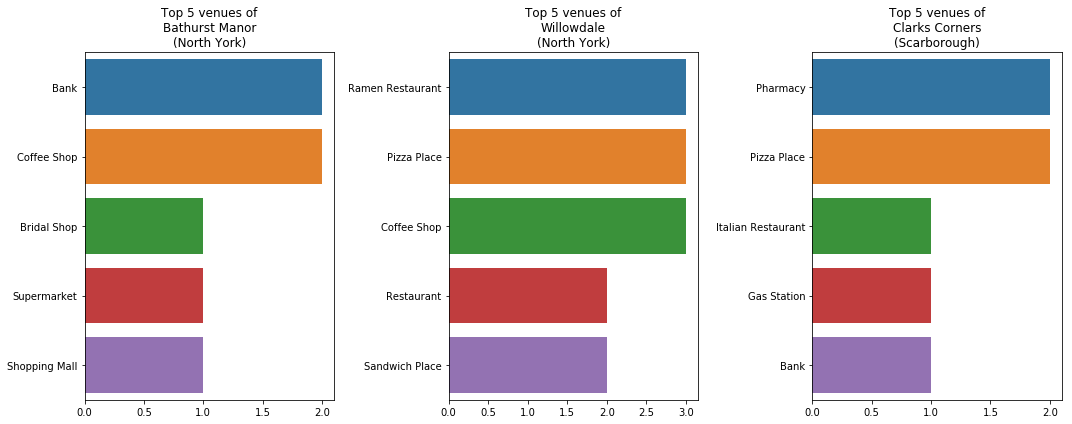

In [1222]:
# Top 5 venues of each neighborhood that falls under cluster 0

neighborhood_analysis(5,0)

Top 5 most common venues of cluster 0 (Toronto) include pizza place, coffee shop, bank, pharmacy, variety of restaurants, and sandwich places. There are just 3 out of 98 neighborhoods of Toronto fall under this cluster

Willowdale has pizza places, coffee shops, and Sandwich places around which means the food industry is already pretty well established here. Bathurst Manor does have coffee shops around but no pizza place or sandwich place. Similarly, Clarks Corners does have pizza places around but not coffee shops or sandwich places. 

Now as the most common venues of the cluster include pizza places and coffee shops at top than it would be a great idea to open up coffee shop, pizza place, or  sandwich place around the neighborhoods which do not have them

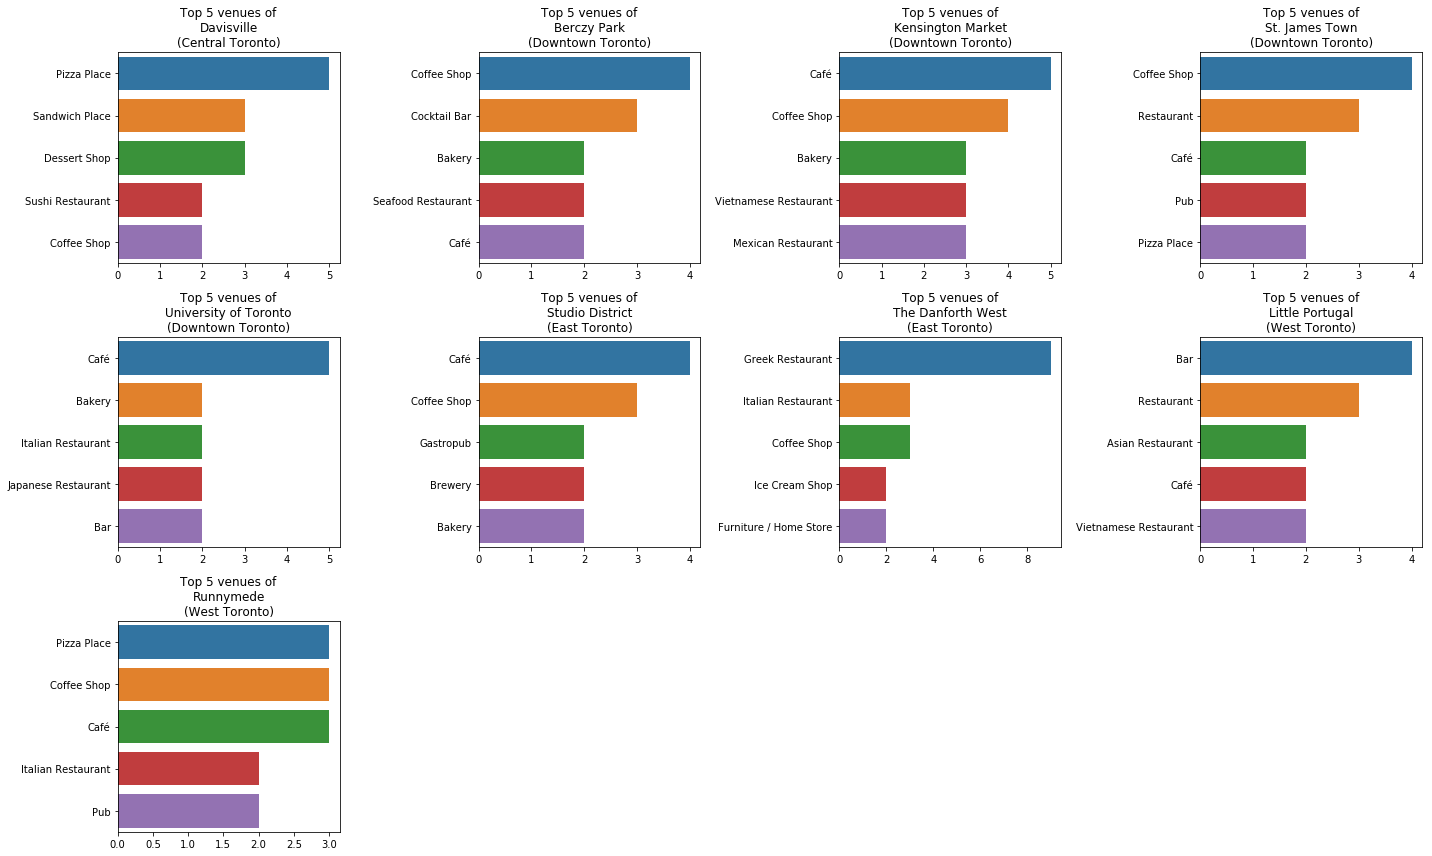

In [1224]:
# Top 5 venues of each neighborhood that falls under cluster 3

neighborhood_analysis(5,3)

Observing the venues of the neighborhoods above, we can clearly say that coffee shop, pizza place, sandwich place, cafe, bakery and bar are very popular among these neighborhoods

As we already observed earlier that the pizza places do not fall under top 20 venues of downtown toronto, it might be a great idea to open up pizza place(s) around Kensington Market, University of Toronto, and Berczy Park

Downtown always has great scope for pubs, bars, clubs and all so opening up pubs or bars in Kensington Market could be a great idea

Sandwich places were one of the most common venues across all the boroughs of Toronto but here we see that none of the neighborhoods have got sandwich places closer to them except Davisville. So opening up a sandwich place also stands a great chance of success

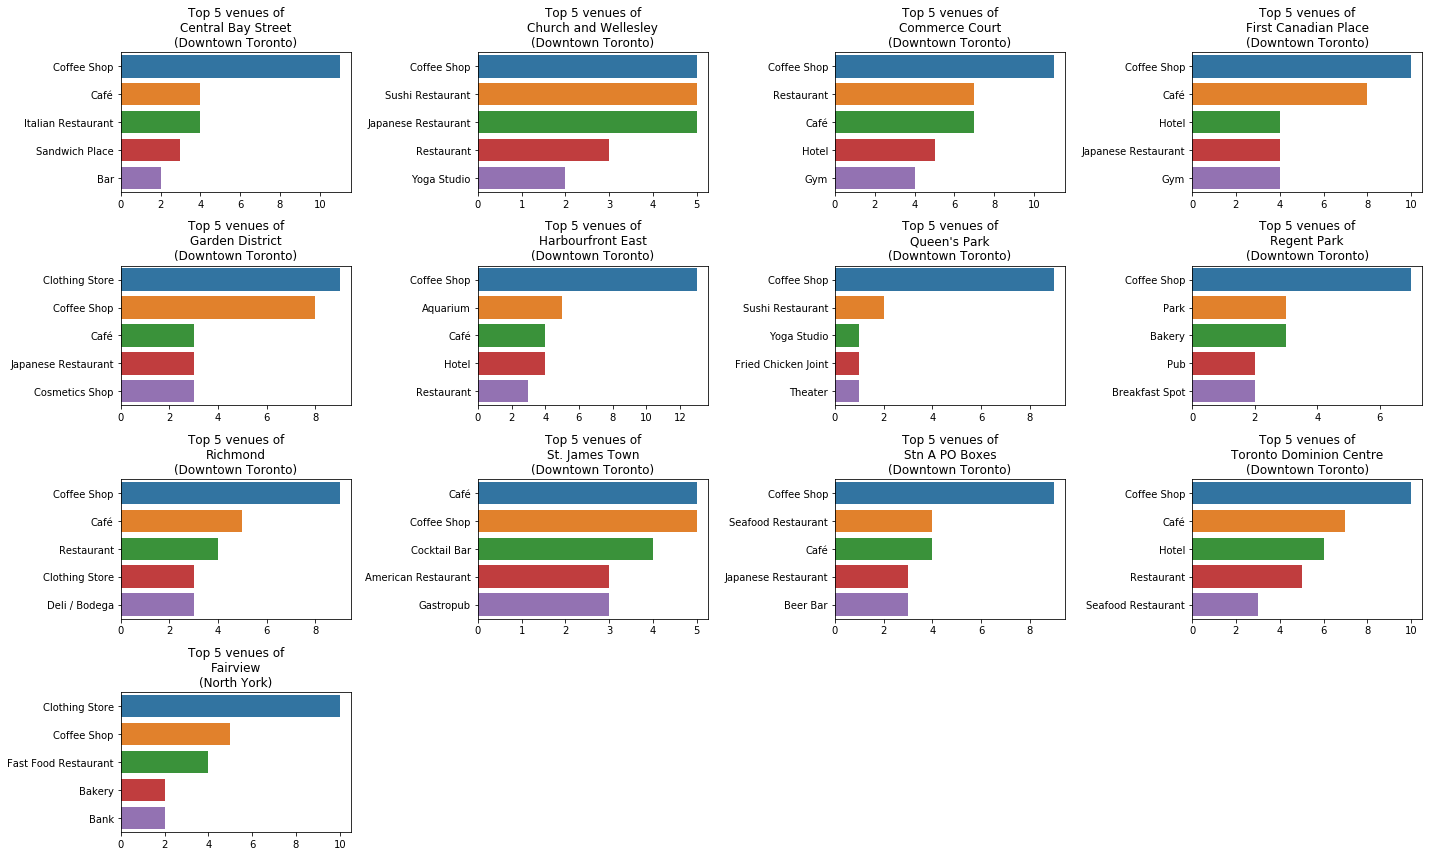

In [1225]:
# Top 5 venues of each neighborhood that falls under cluster 7

neighborhood_analysis(5,7)

We can clearly see that all the neighborhoods falling under cluster 7 are located in Downtown except Fairview which is located in North York. 

Here, we can clearly see that there are plenty of coffee shops, cafe, hotel, variety of restaurants where Japanese restaurants being the most popular ones. It is actually pretty difficult to make any conclusion of opening up any new venues or anything as the places are anyways located very close to each other in the downtown. But it would actually be a great idea of opening up those venues which are completely not seen in the top 5 venues of any neighborhoods. 

First such venue is pizza place as we discussed above that we can not see here at all and it is one of the most popular venues of Toronto. Another very common venue which we have seen all across Toronto is Sandwich places which do not fall in top 5 venues here except one neighborhood that is Central Bay street. 


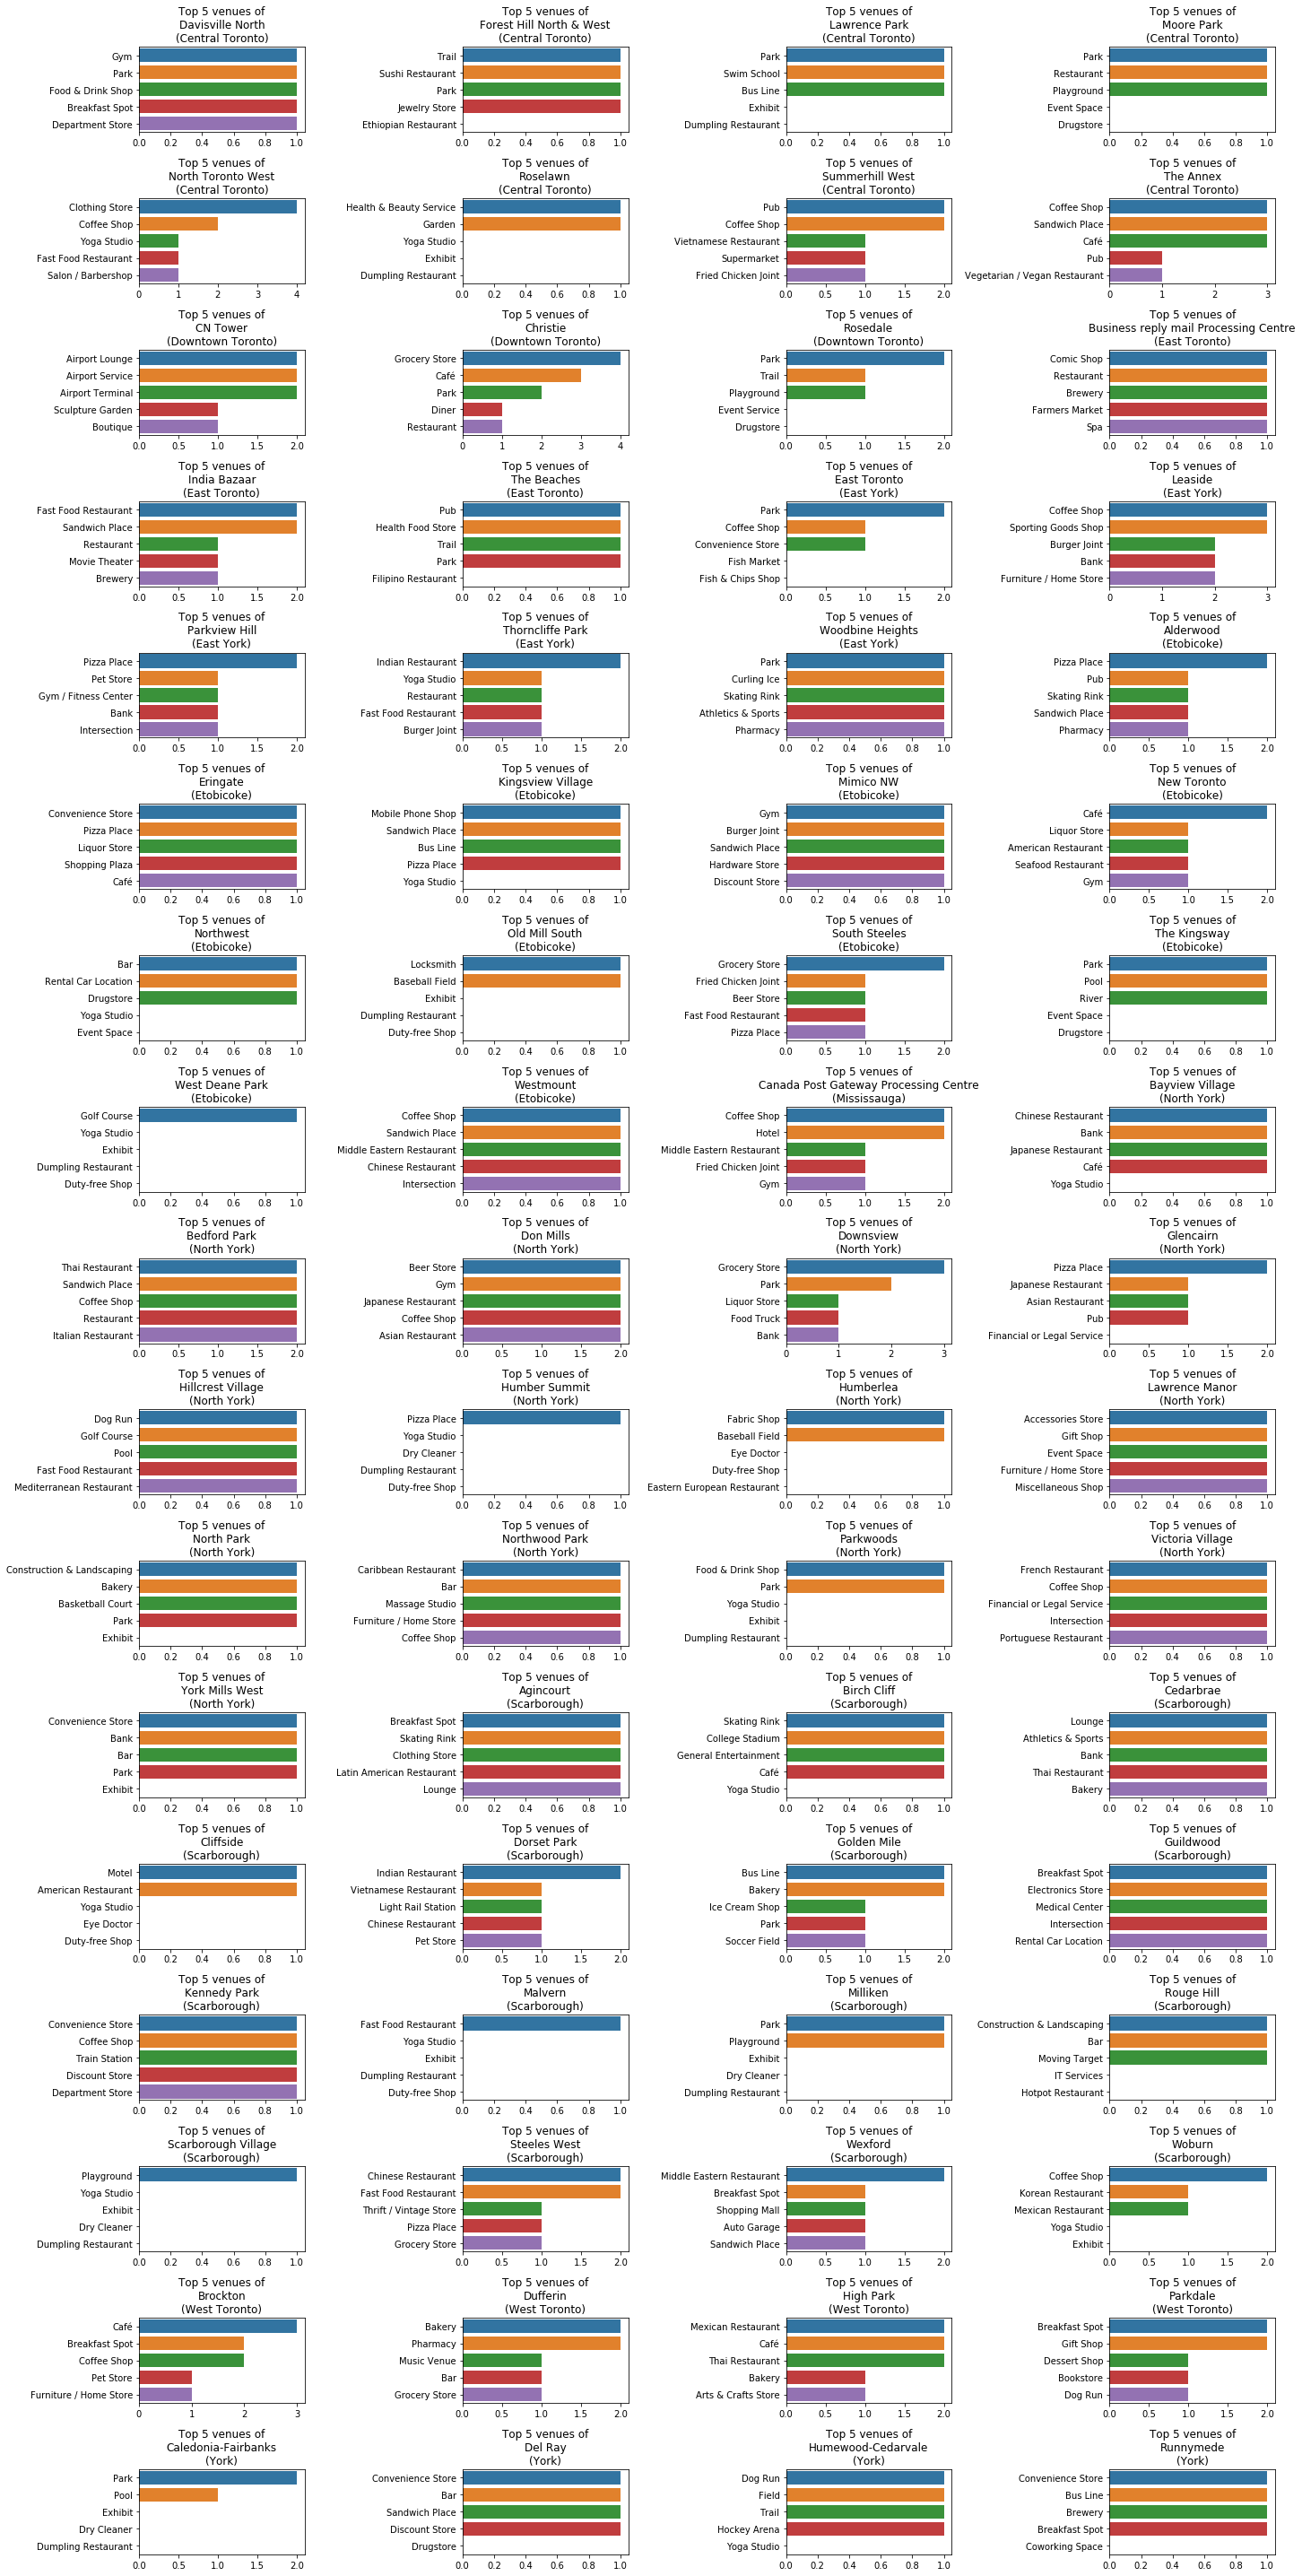

In [1227]:
# Top 5 venues of each neighborhood that falls under cluster 1

neighborhood_analysis(5,1)

As we already saw on the geographical map of the neighborhoods with different clusters, we observed that most of the neighborhoods (72 neighborhoods out of 98) fall under cluster 1. 

The most common venues of cluster 1 are coffee shop, park, sandwich place, cafe, grocery store, and pizza places. From the data above it is very clear that there are not so many venues exist closer to the neighborhoods and assuming the less population density behind this. So these neighborhoods which do not have any of these venues closer to them, defintely reflects a great scope of starting a new business or expanding your business.

Almost all the neighborhoods of Central Toronto falling under this cluster 1 which are (Davisville North, Forest Hill North & West, Lawrence park, Moore park, North Toronto west, Roselawn, Summerhill West, The Annex) show great opportunity of opening up cafe, pizza place, and sandwich place as none of the neighborhoods have these venues closer to them

The other neighborhoods of Toronto like CN Tower(Downtown Toronto), Christie (Downtown Toronto), Rosedale (Downtown Toronto), Business reply mail Processing Centre (East Toronto), India Bazaar (East Toronto), The Beaches (East Toronto) stand show lots of opportunities to expand your business in food industry such as opening coffee shops, cafe, pizza places, and sandwich places as well. Starting a new business wouldn't be recommendable as these venues do not seem to be very populated and permanently livable places

The neighborhoods of East York has got few pizza places and coffee shops close by but still there is high scope of opening up cafe, sandwich places, and grocery stores 

Sandwich place and pizza place are most popular among the neighborhoods of Etibicoke in this cluster. There are few neighborhoods with coffee shops, park, and grocery store around them. So the neighborhoods like Kingsview village, Mimico NW, New Toronto, Northwest, and South Steeles could have great opportunities of opening up coffee shop, or cafe as most of these neighborhoods do have sandwich places and pizza places already located there which is shows positive sign of growing food industry there

The neighborhoods of North York falling under this cluster seem to have lot of opportunities for food industry to grow. There are 14 neighborhoods of North York in this cluster and very few of them have coffee shops and pizza place closer to them. All the neighborhoods have absolutely uncommon venues like dog run, golf course, fabric shop, gift shop, miscellaneous shop, construction and landscaping and so many like that. Having highest population among all the boroughs of Toronto and second largest land area, it could be possible that the venues are located far away as they have got plenty of land and neighborhoods to reach to. That could be the reason why the stores are not available within 500 meters (0.3 miles) of distance from a particular neighborhood but if that is not true in all the cases than North York stands a great chance of development and offers great opportunities to develop and grow the food industry 

Similar theory is applicable to neighborhoods of Scarborough as well. It can be clearly observed that the neighborhoods have variety of restaurants closer to them than the basic coffee shop, cafe, pizza place, grocery store, pharmacy or anything like that. The neighborhoods Birch cliff, Kennedy park, Rouge hill, Steeles west, and Woburn has got either coffee shop, cafe, or a pizza place. So this borough also stands a great chance of opening up any business in the food industry as they already have got the restaurants around

Same thing is applicable to the neighborhoods of West Toronto and York

## Analysis of neighborhoods of NYC cluster wise

In [1228]:
nyc_analyse = pd.DataFrame()

for boroughs in nyc_borough_list:
    nyc_analyse = nyc_analyse.append(tornyc_grouped[tornyc_grouped["Borough"] == boroughs],
                                                                       ignore_index = True)
nyc_analyse.head(3)

Borough  Neighborhood  Cluster Labels  Accessories Store  Adult Boutique  \
0   Bronx      Allerton               0                  0               0   
1   Bronx    Baychester               1                  0               0   
2   Bronx  Bedford Park               0                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   

   Animal Shelter  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0               0             0         0       0                 0   
1               0             0         0       1                 0   
2               0             0         0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                     0                 0                   0           0   
1                     0                 0                   0           0   
2                     0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Badminton Court  Bagel Shop  \
0                0          0           0                0           0   
1                0          0           0                0           0   
2                0          0           0                0           0   

   Bakery  Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0       0     0    0               0                 0                 0   
1       0     1    0               0                 0                 0   
2       0     0    1               0                 0                 0   

   Basketball Stadium  Bath House  Beach  Beach Bar  Bed & Breakfast  \
0                   0           0      0          0                0   
1                   0           0      0          0                0   
2                   0           0      0          0                0   

   Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  \
0         0            0           0                   0              0   
1         0            0           0                   0              0   
2         0            0           0                   0              0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0              0          0         0              0           0   
1              1          0         0              0           0   
2              0          0         0              0           0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  Bridge  \
0                     0               1        0

In [1270]:
def neighborhood_analysis(num, cluster_label):
   
    fig, ax = plt.subplots(nrows = math.ceil(len(nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label])/4), 
                           ncols=4, 
                           figsize= (20,12),
                           squeeze = False)
    n=0
    m=0

    for i in range(0,len(nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label])):
        yy = nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label].iloc[i,3:].sort_values(ascending=False).head(num).index
        xx = nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label].iloc[i,3:].sort_values(ascending=False).head(num).values
        
        sns.barplot(y= yy, 
                    x=xx,
                    ax = ax[n,m])
        
        ax[n,m].set_title("Top {} venues of\n{}\n({})".format(num, 
                                                    nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label]["Neighborhood"].values[i],
                                                    nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label]["Borough"].values[i]))
        m = m+1
        
        if m == 4:
            n = n + 1
            m=0
    
    for empty_plot_num in np.arange(len(nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label]), 
                                math.ceil(len(nyc_analyse[nyc_analyse["Cluster Labels"] == cluster_label])/4)*4):
        fig.delaxes(ax.flatten()[empty_plot_num])

    

    return plt.tight_layout()

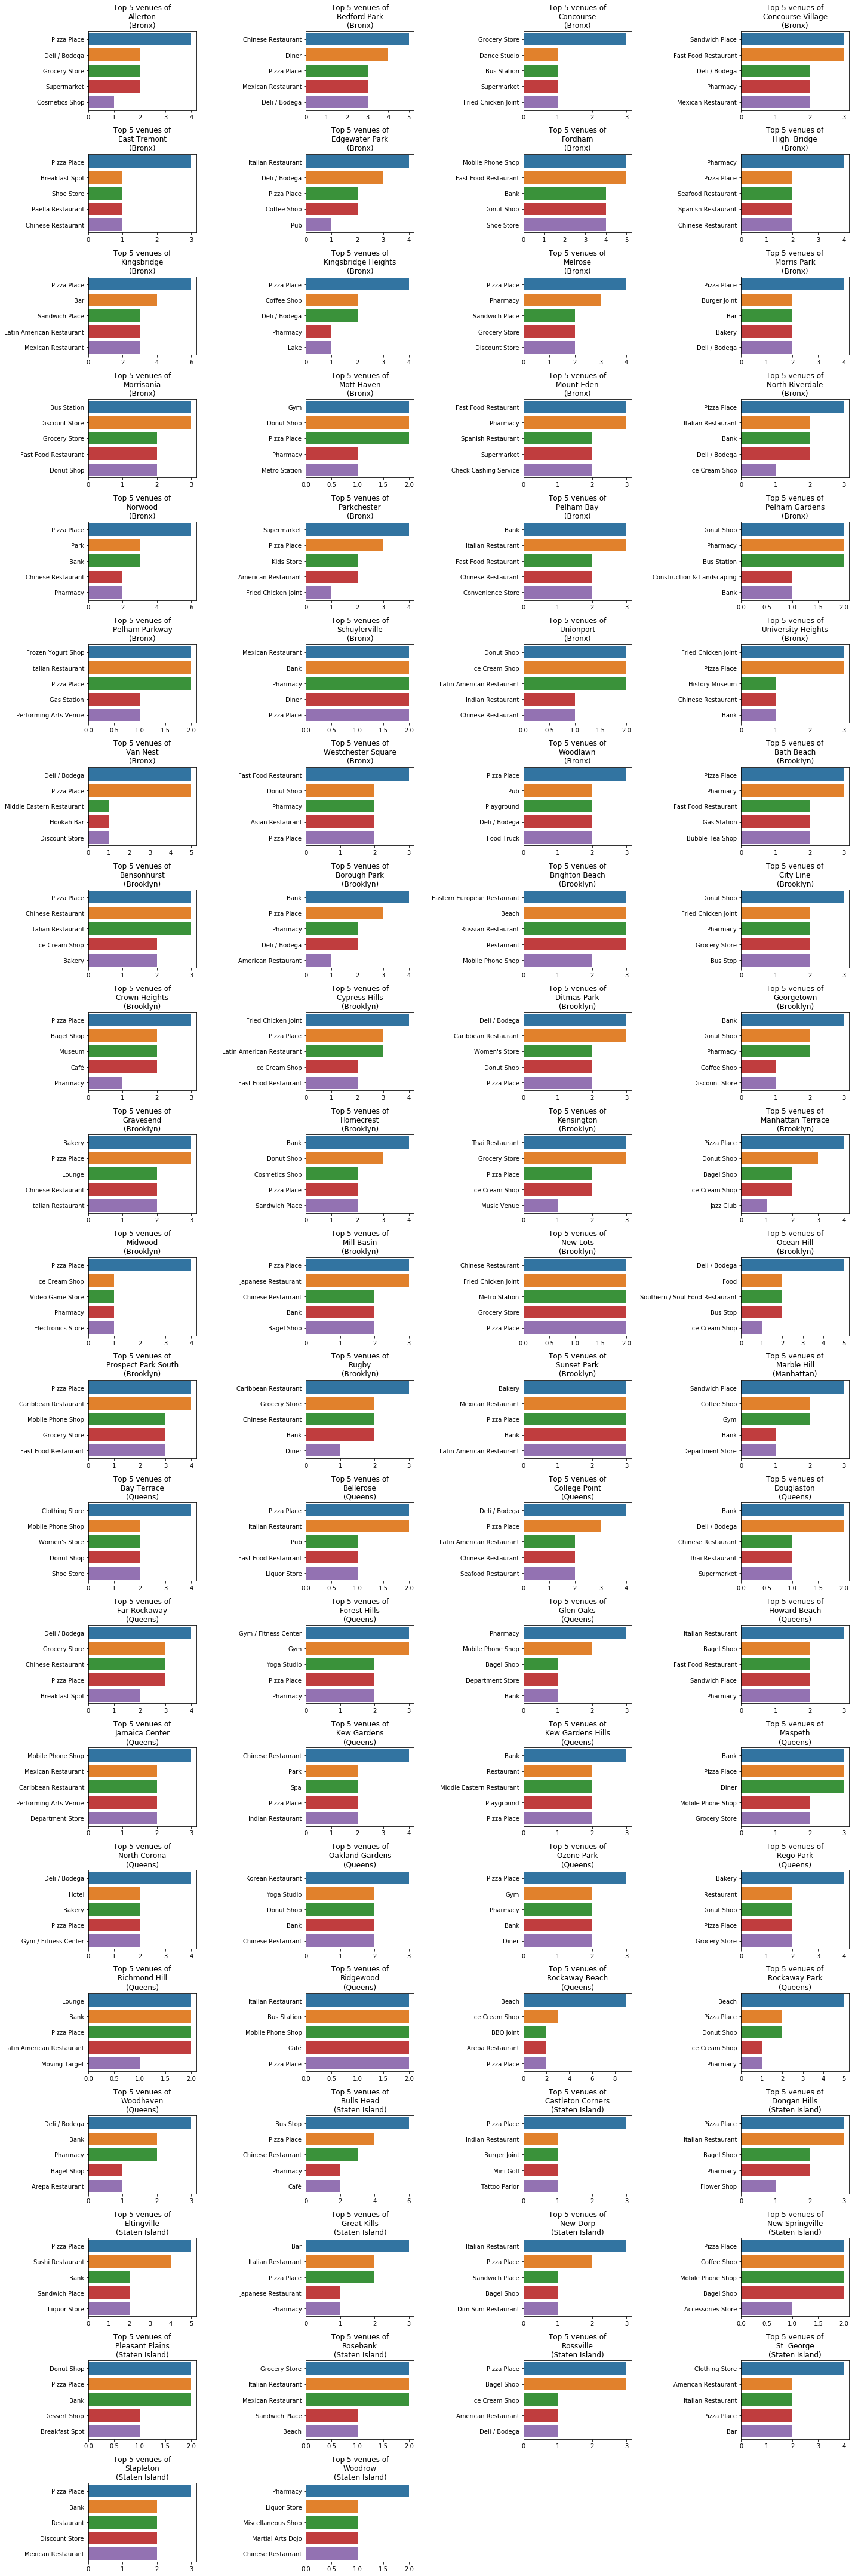

In [1232]:
# Top 5 venues of each neighborhood that falls under cluster 0

neighborhood_analysis(5,0)

82 of 305 neighborhoods, fall under cluster 0. Top five most common venues of this cluster are pizza place, deli/bodega, pharmacy, bank, and donut shop. 

27 of 51 neighborhoods of Bronx are in this cluster. We can clearly see that coffee shops and cafe are less popular compare to pizza places and donut shops. Deli/bodega and grocery stores exist everywhere very close by to almost all the neighborhoods. Pharmacies are also located very close to most of the neighborhoods. We saw earlier that pizza place is the most popular venue in Bronx and donut shop is third most popular venue. Both of these are popular venues of the clusters as well. So here I have tried to find the neighborhood where opening either of them proved beneficial. Concourse, Concourse village, Mount Eden, and are Pelham Bay are the neighborhoods where neither pizza places nor donut shops fall in top 5 venues so these neighborhoods would be the best possible locations in Bronx to start the business

20 of 70 neighborhoods of Brooklyn are in this cluster. We can observe that pizza place and donut shop are popular in the neighborhoods of Brooklyn as well. Different neighborhoods have got variety of restaurants close to them where Chinese restaurants being most popular one. One interesting thing to observe is that deli/bodega or grocery stores are not that close to many of these neighborhoods. So most of the neighborhoods stand a great chance to open up more deli/bodega or grocery stores at. Other neighborhoods such as Brighton Beach, Ocean Hill, and Rugby do not have any pizza places or donut shops around so that could be great neighborhoods to open up more pizza places or donut shops

There is only one neighborhood of Manhattan in this cluster which has little different qualities than others that it has more coffee shops and sandwich places around than pizza place, donut shop, or deli/bodega

21 of 81 neighborhoods of Queens fall under this cluster. We can observe that Deli/bodega being the most popular venue among all the neighborhoods and pizza places and donut shops are behind it. One more interesting observation is that few of the neighborhoods such as Bellerose, College point, Douglaston, Howard beach, Jamaica center, Kew gardens, Kew garden hills, Oakland gardens, Rockaway beach, Woodhaven have got at least two or more restaurants around them. As it is very diversified in terms of its venues it would be pretty difficult to find out the location but still there few neighborhoods such as Douglaston, Glen oaks, Howard beach, and Woodhaven which do not pizza places or donut shops around although they have got many restaurants around them

13 of 62 neighborhoods of Staten Island are part of this cluster. Pizza place being the most popular venue among all the neighborhoods; Italian restaurants, bagel shops and sandwich places are pretty common. Pharmacies are also available in good numbers around the neighborhoods. Donut shop and deli/bodega almost do not have any existence as one of the top 5 venues of any neighborhood except Pleasant Plains and Roseville. So all these 13 neighborhoods under cluster 1 stand a great chance to start business by opening donut shops or deli/bodega

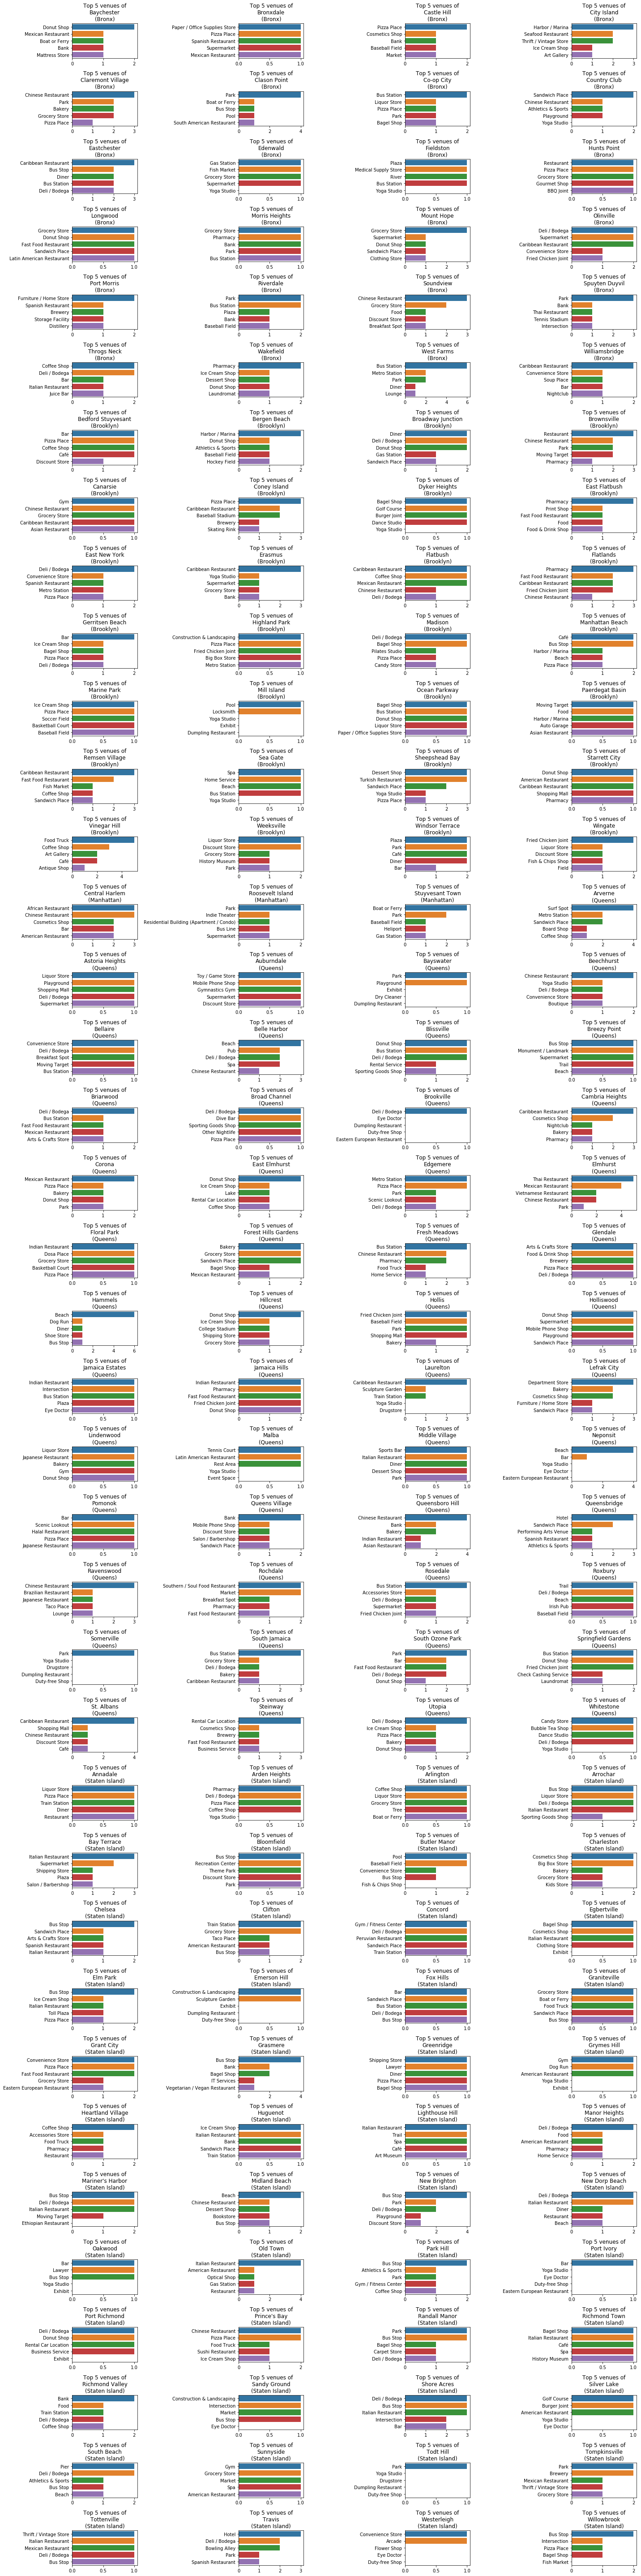

In [1235]:
# Top 5 venues of each neighborhood that falls under cluster 1

neighborhood_analysis(5,1)

152 of 305 neighborhoods fall under cluster 1. Top five most common venues of this cluster are deli/bodega, pizza place, park, Chinese restaurant, and bus stops. Donut shops, Italian restaurants, and sandwich places are behind top five venues. Coffee shops and cafe are among the last 5 venues out of top 20 venues of cluster 1. 

24 of 51 neighborhoods of Bronx lie in cluster 1. There is no such trend of popular venues can be found in the neighborhoods of Bronx lying in this cluster. There are few of the neighborhoods such as Longwood, Morris Heights, mount Hope, and Olinville where grocery stores or deli/bodega are more popular and there are few other neighborhoods such as Bronxdale, Castle Hill, Claremont village, Co-op city, and Hunts point where pizza place are popular as they lie in top 5 venues. Coffee shops or donut shops are not found in top 5 except one or two neighborhoods. Another interesting thing to observe is that there are anyways very few venues around the neighborhoods compare to what we observed in cluster 0. So probably all these neighborhoods stand a great chance to start a new business whether it be a coffee shop, pizza place, donut shop, bagel shop, pharmacy, or deli/bodega

28 of 70 neighborhoods of Brooklyn lie in this cluster. Pizza place is more common across different neighborhoods but again it is difficult to see a trend as the top 5 venues of the neighborhoods keep changing and have some uncommon venues as well. Neighborhoods such as Bedford Stuyvesant, Broadway junction,Brownsville,East New York, Flatbush, Gerritsen Beach, Madison, Manhattan beach, Ocean Parkway, Starrett city, Vinegar Hill, and Windsor terrace are the neighborhoods which show ordinary characteristics in terms of venues around it as they have got donut shops, pizza places, bars, pubs, coffee shops, bagel shops, pharmacies around them. There are few unique neighborhoods such as Bergen Beach (venues: harbor,Baseball field and Hockey field), Coney Island (Venues: Baseball stadium, Carribean restauarant, skating rink), Dyker Heights (venues: Golf course, dance studio, yoga studio), Highland park (venues: Construction and landscaping, big box store, metro station), Marine park (Venues: soccer field, basketball court, baseball field), and Vinegar Hill (venues: Food truck, art gallery, antique shop). So similarly all these neighborhoods stand a great chance to start a new business whether it be a coffee shop, pizza place, donut shop, bagel shop, or sandwich place

There are just 3 neighborhoods of Manhattan which fall under cluster 1. They have variety of restaurants around them and unique venues such as Indie theatre, Boat or Ferry, Baseball field, and Heliport

49 out of 81 neighborhoods of Queens fall under cluster 1. Deli/bodega being most popular across so many neighborhoods and pizza place, donut shop, bagel shop, coffee shop, cafe are found here and there in few neighborhoods.There are plenty of bus stops and bus stations around the neighborhoods.One interesting thing to be observed is that there are very few number of venues around each neighborhood if that venue is not being any type of restaurants. There are so many neighborhoods which have got many different types of restaurants within 500 meters of radius. Those neighborhoods are Elmhurst (venues: Thai, Mexican, Vietnaam, Chinese restaurants), Pomonoc (venues: Halal and Japanese restaurants), Queensboro Hill (venues: Chinese, Indian, Asian), Ravenswood (venues: Chinese, Brazilian, Japanese), Rochdale (venues: Southern/Sould food restaurant, breakfast spot, fast food restaurant), St. Albans (venues: Carribean and Chinese restaurants). We observed the same thing in cluster 0 which proves that Queens has the most diversified culture compare to other boroughs of NYC. There are four neighborhoods which have got plenty of beaches within 500 meters of radius which are Belle Harbor (3 beaches), Hammels (6 beaches), Neponsit (4 beaches), Roxbury (1 beach). As most of these neighborhoods do not have pizza places, coffee shops, donut shops, or sandwich places close to so many of the neighborhoods, it would be a great idea to open up any of these stores taking the other surroundings and mandatory parameters into consideration

48 out of 62 neighborhoods of Staten Island fall under cluster 1. Deli/bodega being most popular across most of the neighborhoods and then comes Italian restaurants which are seen around many neighborhoods. Pizza place, bagel shop, and American restaurants are the other venues which are found across many neighborhoods as well. Neighborhoods which have two or more top most common venues of cluster 1 are Arden Heights, Arrochar, Chelsea, Concord, Egbertville, Elm park, Fox hills, Graniteville, Grantcity, Huguenot, Manor heights, Mariner's harbor, New Dorp beach, Old Town, Prince's bay, Randall Manor, Richmond town, Shore Acres, South Beach, Tottenville, and Willowbrook. All these neighborhoods show great prospect to open up any business or expand any business related to food industry such as deli/bodega, bagel shop, donut shop, sandwich places, coffee shops or cafes. Other than that all the other neighborhoods have shown one or no top most common venues of cluster 1 so these neighborhoods also stand the chance to open up any of the business related to food industry after careful observation of surrounding venues and other considerable parameters

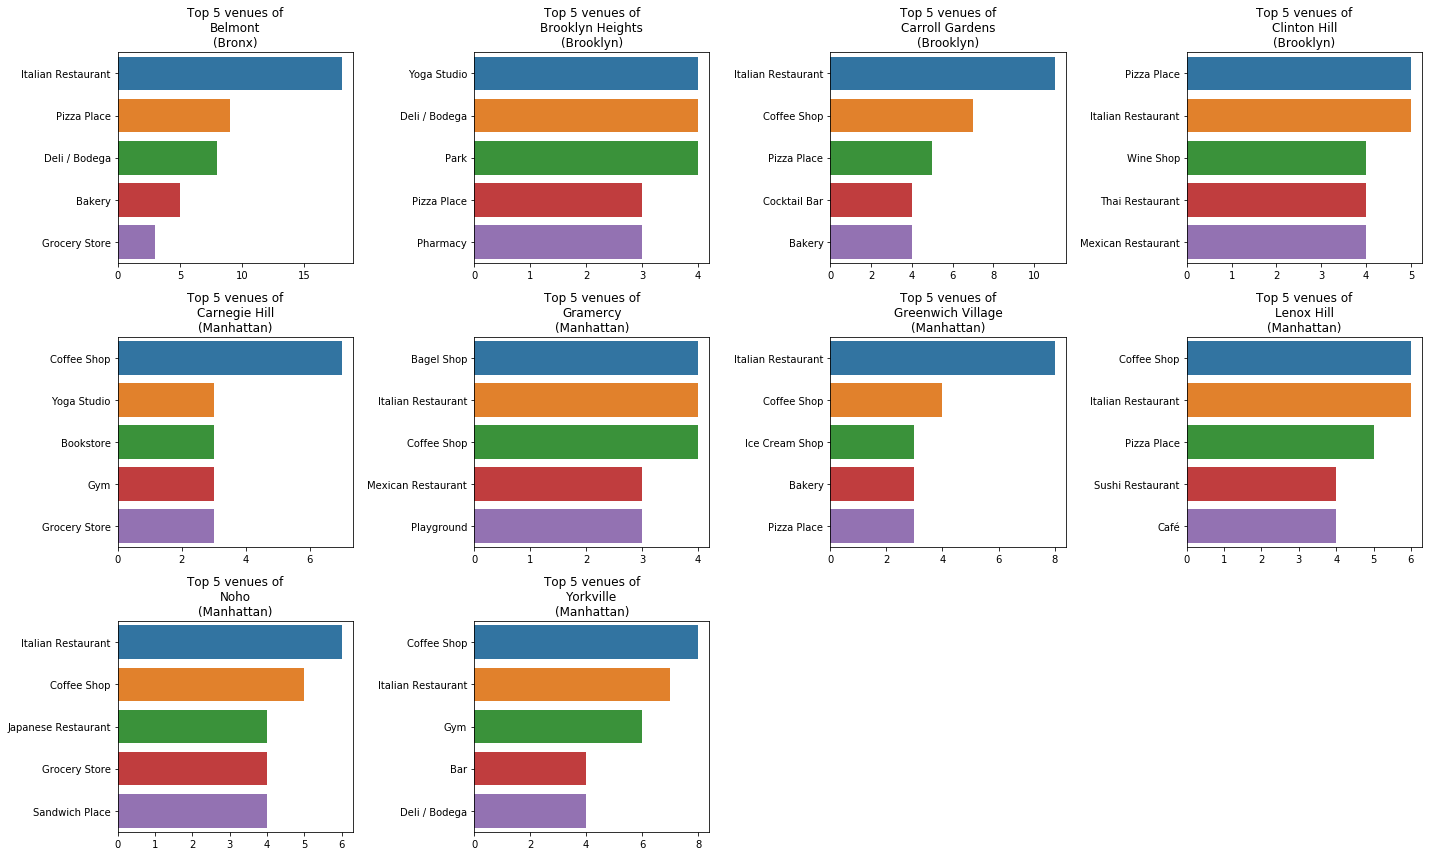

In [1239]:
## Top 5 venues of each neighborhood that falls under cluster 2

neighborhood_analysis(5,2)

Cluster 2 has got very few neighborhoods but it involves lot more neighborhoods of Manhattan than cluster 0 and cluster 1. With more neighborhoods of Manhattan we see the change in top most common venues of the cluster. Italian restaurant is the top most common venue whereas coffee shop and pizza place are other most common venues across cluster 2. One more interesting observation is that all these common venues exist in very large number within 500 meters (0.3 miles) of radius. Belmont of Bronx and Carroll Gardens of Brooklyn is called little Italy and we can clearly analyse the same thing from the bar plot 

There are already numerous venues exist within 0.3 miles of radius of all these neighborhoods. From the bar plot of cluster 2, we can say that there are donut shop and bagel shop also exist around these neighborhoods. Because of already tightly packed neighborhood, the best thing would be not to get into any these neighborhoods to start any new business related to food industry 

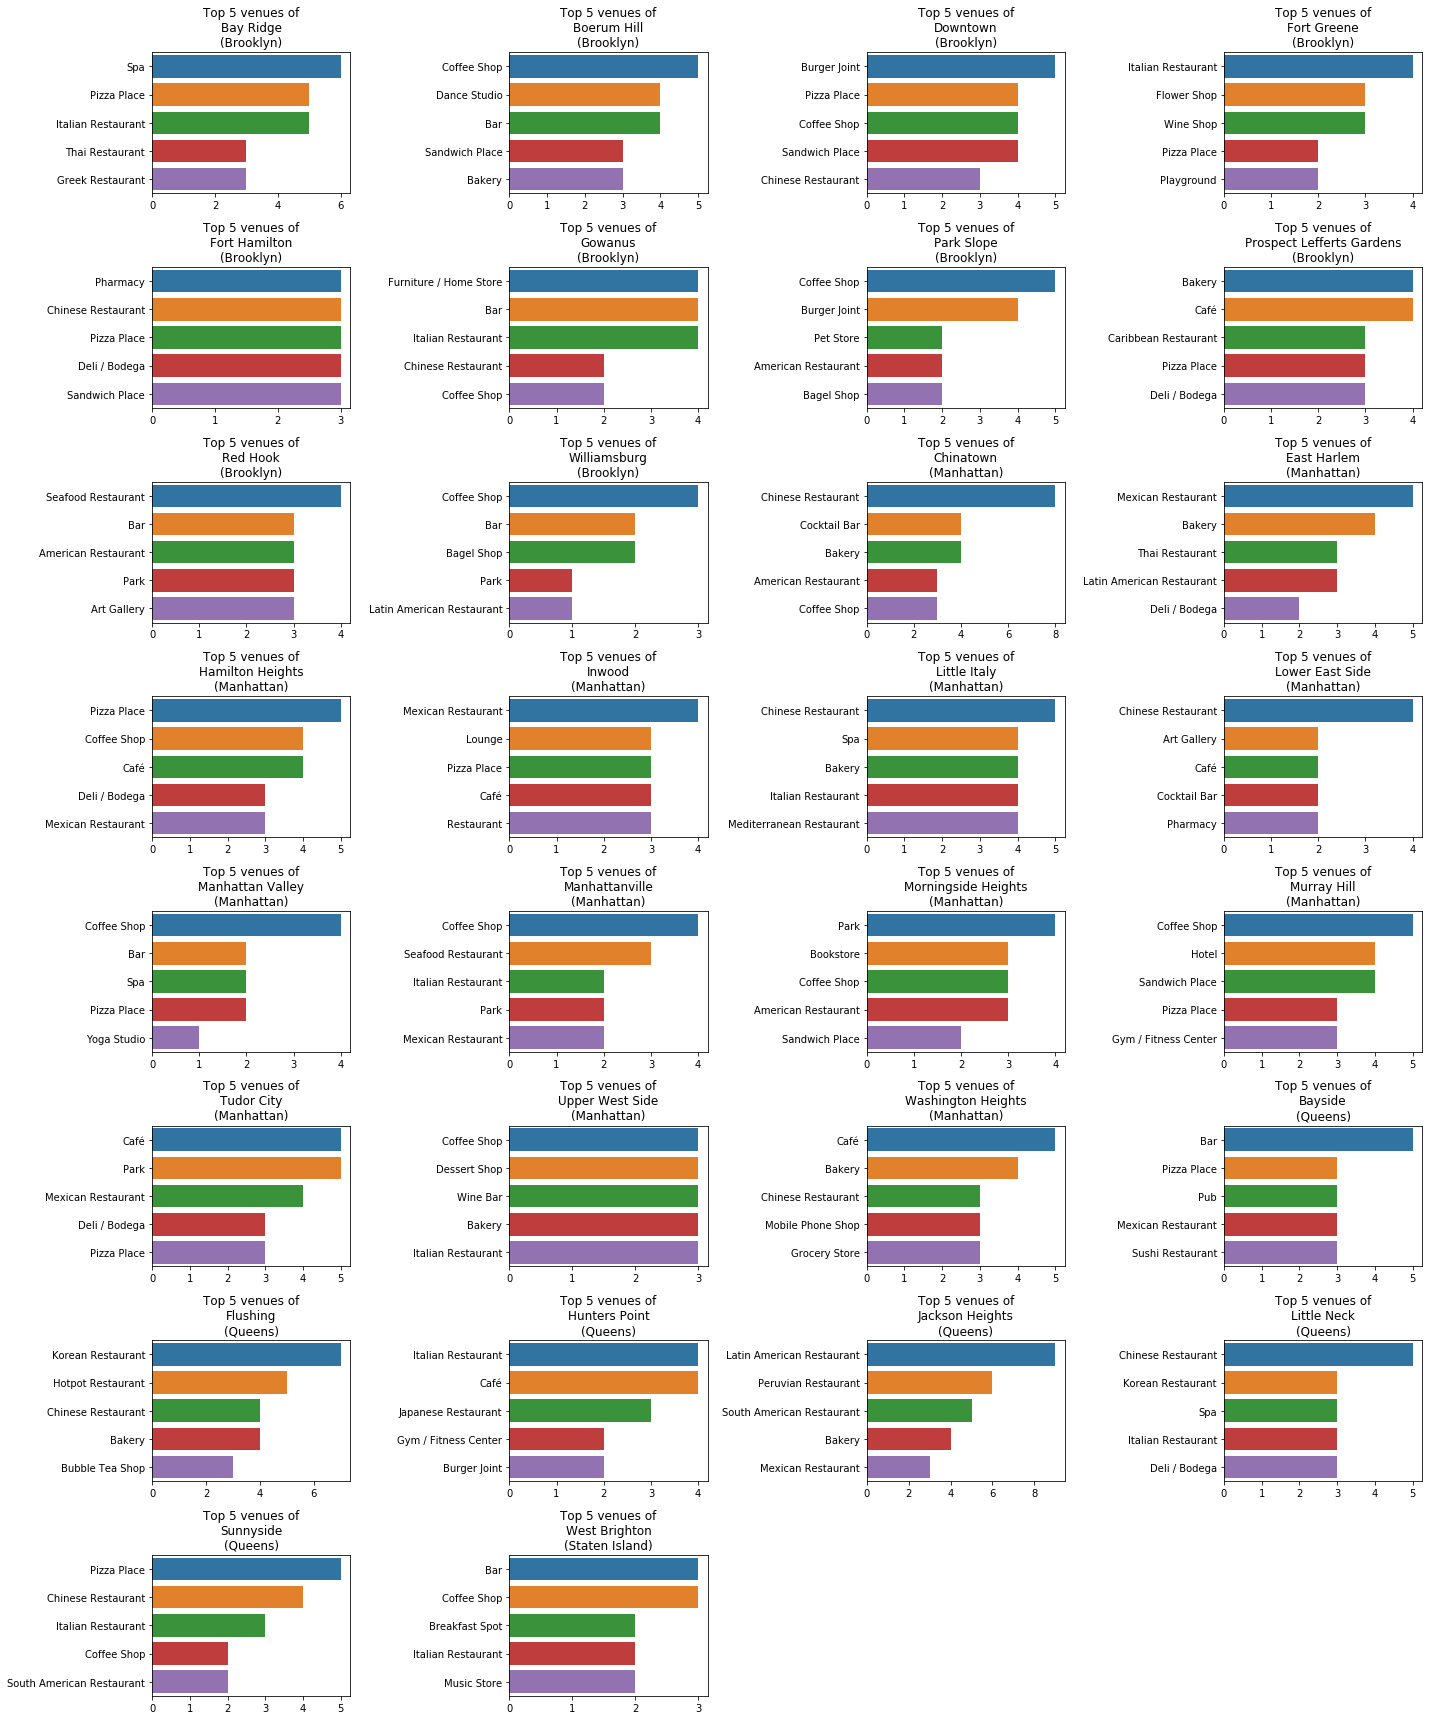

In [1243]:
# Top 5 venues of each neighborhood that falls under cluster 3

neighborhood_analysis(5,3)

We can observe that few neighborhoods of Brooklyn and many neighborhoods of Manhattan (13 out of 40) show little different characteristics and fall under this cluster 3. It is very clear that coffee shops and pizza places are the most common venues of this cluster. The bar plot of top 20 most popular venues of cluster 3 showed the same thing as well and in that plot also we can clearly see that pizza places and coffee shops exist almost in same numbers. 

Out of 10 neighborhoods of Brooklyn, few of the neighborhoods have more coffee shops like Boerum Hill, Gowanus, Park Slope, and Williamsburg whereas few neighborhoods have more pizza places like Bay Ridge, Fort Greene, Fort Hamilton, and Prospect Lefferets Gardens and Downtown Brooklyn has got both the places in top 5 most common venues. We can observe few common venues which we have seen earlier like deli/bodega, bagel shop, sandwich places, Chinese and Italian restaurants but they just exist in one or two neighborhoods. From the geographical map it seems that these neighborhoods are around Downtown area and therefore it would be great idea to open up a pizza place or coffee shops in the neighborhoods where they do not exist as described above or open up sandwich places as it exists in few of the neighborhoods but not in all of them. So neighborhoods like Fort Greene, Gowanus, Park Slope, Prospect Lefferets Gardens, and Williamsburg might be good prospects looking at their surroundings

Coffee shops, Chinese restaurants, and cafe are the most popular venues in the neighborhoods of Manhattan. From the geographical map it can be clearly seen that few of these neighborhoods are around downtown and others are lying near to the shoreline. We can see the two neighborhoods Chinatown and Little Italy which reflect the community located over there. As they already have plenty of local restaurants there and they are tightly packed with them, they shouldn't be the first choice to start any new business. Neighborhoods like Inwood, Manhattan Valley, Lower East Side, Manhattan Valley, Manhattan ville, Morningside heights, Murray Hill, Tudor city, and Upper West side seem to share very similar characteristics with each other according to their surrounding venues so to start any business or expand anything related to food industry than these neighborhoods might be a good prospect

As we have already observed in the neighborhoods of Queens that there are lots of restaurants of different varieties so those places wouldn't be the best places to start any new business in the food industry. Now, there are two neighborhoods which have got plenty of coffee shops and pizza places around them and they fall in top 5 most common venues as well like Bayside and  Sunnyside

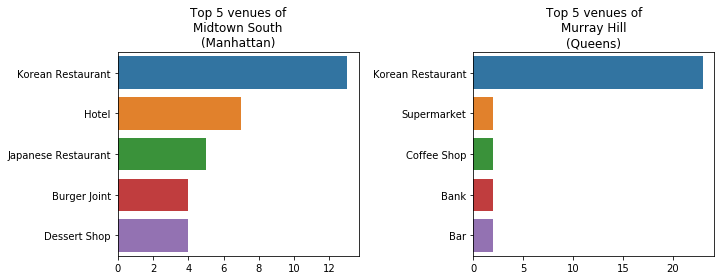

In [1254]:
# Top 5 venues of each neighborhood that falls under cluster 4

neighborhood_analysis(5,4)

Here, we can clearly see that both of these neighborhoods have got Korean community living there. So deciding to open up any new business in local community based on the preferences of diversified community would not be a great idea 

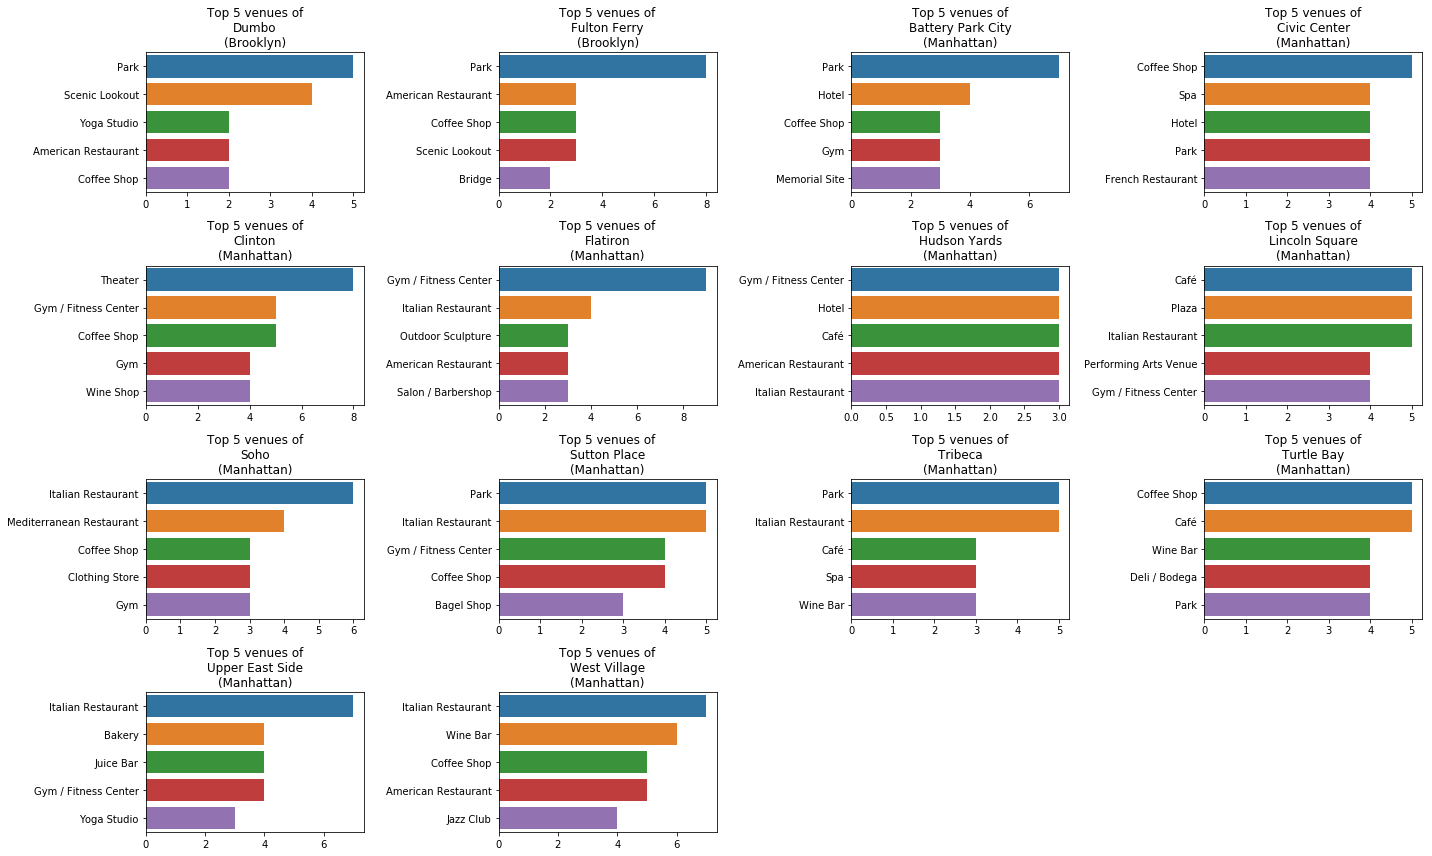

In [1260]:
# Top 5 venues of each neighborhood that falls under cluster 5

neighborhood_analysis(5,5)

We can clearly observe from the plots above that these neighborhoods have completely different characteristics than the other neighborhoods of other clusters. The reason behind that is all these neighborhoods belong to core downtown areas of their own Borough.

From the geographical map we can observe that both the neighborhoods of Brooklyn; Dumbo and Fulton Ferry, lie almost at the border of downtown as well as the border of the borough. All the neighborhoods of Manhattan can be seen on the geographical map located in the lower Manhattan which is considered downtown of Manhattan or even downtown of NYC. 

We see parks as the most common venue and then Italian restaurants, coffee shops, gyms, and American restaurants. Pizza place, donut shops, bagel shops do not seem to be very popular around downtown area. Almost all the neighborhoods have three of these popular venues or more except Flatiron, Hudson Yards, Lincoln Square, Tribeca, and Upper East Side which do not have coffee shops in top 5 most common venues. So looking at the surroundings and other required parameters coffee shops could be one of things to open up or expand

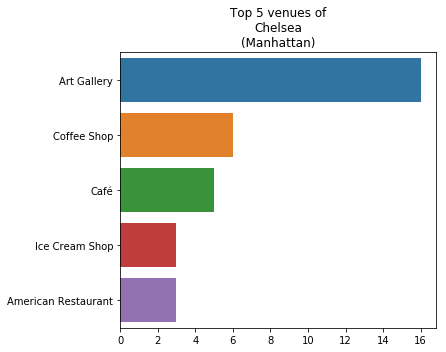

In [1267]:
# Top 5 venues of each neighborhood that falls under cluster 6

neighborhood_analysis(5,6)

Chelsea, Manhattan is popular for its arts galleries which we can clearly see from the plot above

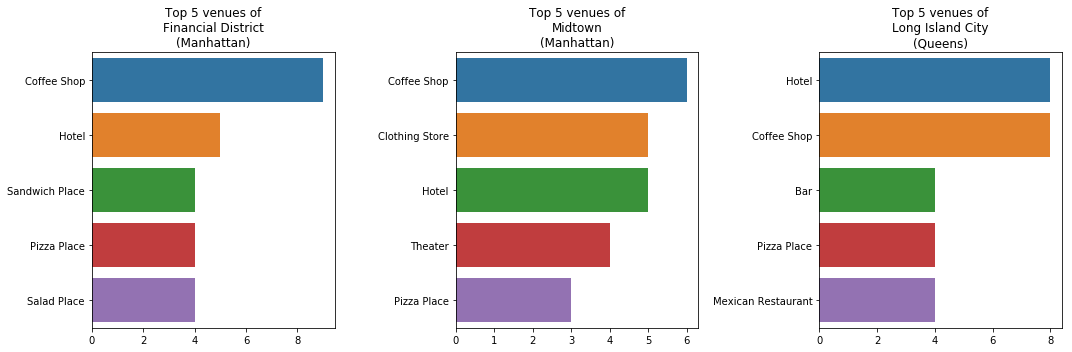

In [1268]:
# Top 5 venues of each neighborhood that falls under cluster 7

neighborhood_analysis(5,7)

It can be clearly seen that these three neighborhoods have coffee shops, hotel, pizza places in common. The bar plot of top 20 venues of cluster 7 also say that these neighborhoods have got sandwich places, donut shops, parks, cafe, and few restauratns around them as well. So they already have too many venues tightly packed around them so it would be difficult to start any new business over here

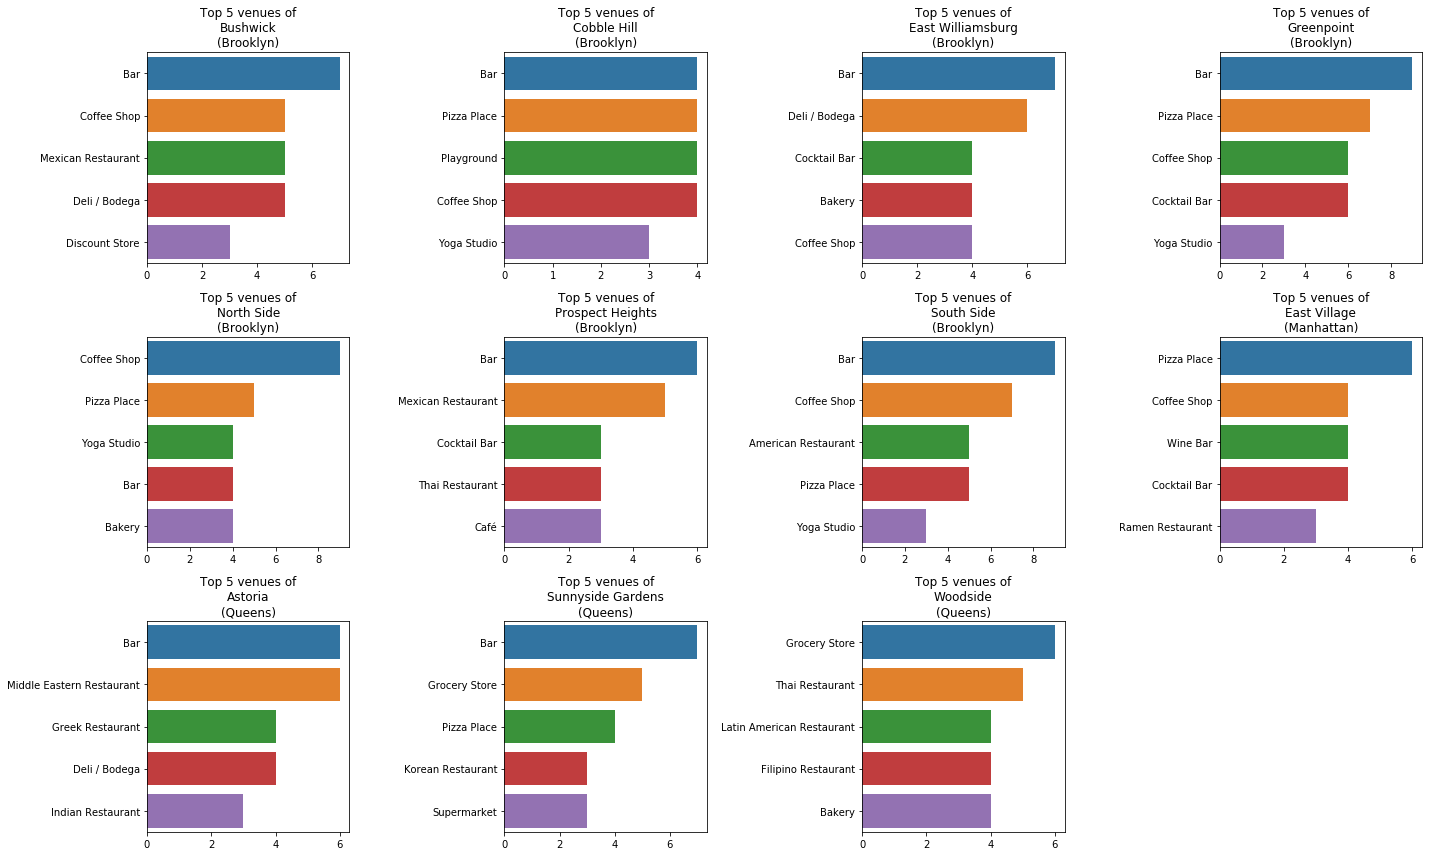

In [1271]:
# Top 5 venues of each neighborhood that falls under cluster 8

neighborhood_analysis(5,8)

We can clearly see that the most popular venue of this cluster is bar. We see numerous bars in all the neighborhoods of Brooklyn. Pizza place and coffee shops are other popular venues around these neighborhoods. There are few neighborhoods of Brooklyn and East village of Manhattan which have numerous cocktail bars as well. These neighborhoods have already got plenty of venues tightly packed around them so it is again pretty difficult to start any new business or anything like that but with these many bars around and pizza place and coffee shops being the other popular venues, it would definitely be a great idea to open up pizza place or coffee shop in the neighborhood which doesn't have any of these. Bushwick, East Williamsburg, Prospect Heights of Brooklyn and  Astoria, and Woodside of Queens stand a great chance to open up a pizza place. Similarly, Prospect heights of Brooklyn and Astoria and all the three neighborhoods of Queens stand a great chance to open up a new coffee shop 

# END